In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from tqdm import tqdm
import math

In [3]:
base_path = '/Users/nyki/Desktop/2025/Research Project/EarlySignalDetection'

#### Data Loading & Preprocessing

In [4]:
DEMO_S = pd.read_parquet(f'{base_path}/RAW_DATA.parquet/DEMO_S.parquet')
REAC_S = pd.read_parquet(f'{base_path}/RAW_DATA.parquet/REAC_S.parquet')
DRUG_S = pd.read_parquet(f'{base_path}/RAW_DATA.parquet/DRUG_S.parquet')
OUTC_S = pd.read_parquet(f'{base_path}/RAW_DATA.parquet/OUTC_S.parquet')

In [5]:
un_set = set(DEMO_S.primaryid) & set(REAC_S.primaryid) & set(DRUG_S.primaryid)

In [6]:
DEMO = DEMO_S[DEMO_S.primaryid.isin(un_set)]
REAC = REAC_S[REAC_S.primaryid.isin(un_set)]
DRUG = DRUG_S[DRUG_S.primaryid.isin(un_set)]
OUTC = OUTC_S[OUTC_S.primaryid.isin(un_set)]

In [7]:

REAC.pt = REAC.pt.astype(str).str.upper()
DRUG.drugname = DRUG.drugname.astype(str).str.upper()

In [ ]:

DEMO.to_parquet(f'{base_path}/RAW_DATA.parquet/DEMO.parquet', index=False)
REAC.to_parquet(f'{base_path}/RAW_DATA.parquet/REAC.parquet', index=False)
DRUG.to_parquet(f'{base_path}/RAW_DATA.parquet/DRUG.parquet', index=False)
OUTC.to_parquet(f'{base_path}/RAW_DATA.parquet/OUTC.parquet', index=False)

In [9]:
del DEMO,REAC,DRUG,OUTC,DEMO_S,REAC_S,DRUG_S,OUTC_S

In [10]:

DEMO_ = pd.read_parquet(f'{base_path}/RAW_DATA.parquet/DEMO.parquet')
REAC_ = pd.read_parquet(f'{base_path}/RAW_DATA.parquet/REAC.parquet')
DRUG_ = pd.read_parquet(f'{base_path}/RAW_DATA.parquet/DRUG.parquet')
OUTC_ = pd.read_parquet(f'{base_path}/RAW_DATA.parquet/OUTC.parquet')
# Date time format convert
DEMO_['fda_dt'] = pd.to_datetime(DEMO_['fda_dt'], format='%Y%m%d')

In [11]:
# Construct year-based database 
DEMO = DEMO_[(DEMO_['fda_dt'].dt.year >= 2004) & (DEMO_['fda_dt'].dt.year <= 2021)]

# filter by time
REAC = REAC_[REAC_.primaryid.isin(set(DEMO.primaryid))]
DRUG = DRUG_[DRUG_.primaryid.isin(set(DEMO.primaryid))]
OUTC = OUTC_[OUTC_.primaryid.isin(set(DEMO.primaryid))]



In [12]:
DEMO.shape[0]

17170608

###### used drug names: PROZAC+SARAFEM+PROZAC WEEKLY+FLUOXETINE HYDROCHLORIDE

In [13]:
# Take target drugname as input
drugnames = input('Enter the drugname: ')

# Seperate multiply drugnames into list
drugname_list = drugnames.split('+')
print(f'Target drug: ', drugname_list)

Target drug:  ['PROZAC', 'SARAFEM', 'PROZAC WEEKLY', 'FLUOXETINE HYDROCHLORIDE']


In [14]:
%%time
# To store unique report identifiers (primaryids) that are associated with the provided drug names
AER_ID = []

for drug in tqdm(drugname_list):
  # filter out rows from DRUG where drugname column is not empty and contais the uppercased target drug name
  # then extract the corresponding & unique report primaryid
    AER_ID_filtered = DRUG[DRUG['drugname'].notnull() & DRUG['drugname'].str.contains(str.upper(drug))].primaryid.unique()

  # cross-reference check with REAC:
  # filter out based on REAC to retain only reports (by primaryid) that appeared in filtered list
    AER_ID_filtered = REAC.loc[REAC['primaryid'].isin(AER_ID_filtered)].primaryid.unique()

  # Append filtered list to main list
    AER_ID.extend(AER_ID_filtered)

AED_ID = pd.Series(AER_ID)
AED_ID = AED_ID.unique().copy()
print('\n', f'Total number of recorded reports about target drug {drugname_list} is: ', len(AED_ID))


# To save computational time and be efficient
set_aedid = set(AED_ID)


100%|██████████| 4/4 [00:31<00:00,  7.78s/it]


 Total number of recorded reports about target drug ['PROZAC', 'SARAFEM', 'PROZAC WEEKLY', 'FLUOXETINE HYDROCHLORIDE'] is:  62481
CPU times: user 29.9 s, sys: 1.04 s, total: 30.9 s
Wall time: 31.2 s


In [15]:
# Extract data that only linked to target drug as our goal dataset
DRUG_GOAL = DRUG[DRUG['primaryid'].isin(set_aedid)]
REAC_GOAL = REAC[REAC['primaryid'].isin(set_aedid)]
DEMO_GOAL = DEMO[DEMO['primaryid'].isin(set_aedid)]
OUTC_GOAL = OUTC[OUTC['primaryid'].isin(set_aedid)]

print(REAC_GOAL.columns)
print(DEMO_GOAL.columns)
print(OUTC_GOAL.columns)

# Deuplicate
DEMO_GOAL = DEMO_GOAL.drop_duplicates(subset='primaryid', keep='first')
REAC_GOAL = REAC_GOAL.drop_duplicates(subset=['primaryid','pt'], keep='first')


Index(['primaryid', 'pt'], dtype='object')
Index(['primaryid', 'caseid', 'fda_dt', 'event_dt', 'sex', 'occp_cod',
       'reporter_country', 'age_group', 'age_years', 'weight_kg', 'wt_group'],
      dtype='object')
Index(['primaryid', 'outc_cod'], dtype='object')


#### Algorithms Definition

In [16]:
%%time
## The summary of unique AE occurred for target drug
pt_goal = REAC_GOAL.pt.unique()
## Count of unique recorded reports
num_goal_report = REAC_GOAL['primaryid'].nunique()
## Count of both [target AE and all other AE] reports that include both [target drug & all other drugs]
N = REAC['primaryid'].nunique()

## a = Count of reports for target drug that include target AE
a = REAC_GOAL.groupby('pt')['primaryid'].nunique()
## b = Count of reports for target drug tht Not include target AE
b = num_goal_report - a
## c = Count of reports for all other drugs that include target AE
c = REAC.groupby('pt')['primaryid'].nunique() - a
## d = Count of reports for all other drugs that Not include target AE
d = N - a - b - c



# 1.ROR
ror = (a*d) / (b*c)
selnror = np.sqrt(1/a + 1/b + 1/c + 1/d)
ror_lower_bound = np.exp(np.log(ror) - 1.96*selnror)
ror_upper_bound = np.exp(np.log(ror) + 1.96*selnror)

# 2.PRR
prr = (a / (a+b)) / (c / (c+d))
selnprr = np.sqrt(1/a - 1/(a+b) + 1/c - 1/(c+d))
prr_lower_bound = np.exp(np.log(prr)) - 1.96*selnprr
prr_upper_bound = np.exp(np.log(prr)) + 1.96*selnprr

# 3.MHRA (adjusted chi_square)
chi_square = (((np.abs(a * d - b * c) - N * 0.5) ** 2) * N) / ((a+b)*(a+c)*(b+d)*(c+d))

# 4.BCPNN
alpha_i = beta_j = gamma_ij = 1
alpha = beta = 2
c_ij = a
c_i = a+b
c_j = a+c
gamma = (gamma_ij * ((N + alpha)*(N + beta))) / ((c_i + alpha_i)*(c_j + beta_j))

# IC = np.log2(a*N) / (c_i*c_j)
expected_IC = np.log2( ((a + gamma_ij)*(N + alpha)*(N + beta)) / ((N + gamma)*(c_i + alpha_i)*(c_j + beta_j)) )
variance_IC = ((1/np.log(2))**2) * (N - a + gamma - gamma_ij) / (((a + gamma_ij)*(1 + N + gamma)) + ((N - c_i + alpha - alpha_i)/((c_i + alpha_i)*(1 + N + alpha))) + ((N - c_j + beta - beta_j)/((c_j + beta_j)*(1 + N + gamma))))
sd_IC = np.sqrt(variance_IC)
bcpnn_lower_bound = IC025 = expected_IC - 2*sd_IC
bcpnn_upper_bound = expected_IC + 2*sd_IC


# 5.MGPS
ebgm = (a*N) / ((a+b)*(a+c))
selnebgm = np.sqrt(1/a + 1/b + 1/c + 1/d)
ebgm_lower_bound = ebgm05 = np.exp(np.log(ebgm) - 1.96*selnebgm)



# Store the calculation results
signal_tmp_pt = []
for pt in tqdm(pt_goal):
    # Extracted matched primaryid
    set_pid = REAC_GOAL.loc[REAC_GOAL['pt'] == pt, 'primaryid'].unique()

    # Process DEMO_GOAL
    DEMO_GOAL_pt = DEMO_GOAL[DEMO_GOAL['primaryid'].isin(set_pid)]
    def safe_mode(series):
        counts = series.value_counts(dropna=True)
        return counts.idxmax() if not counts.empty else None

    age_group_mode = safe_mode(DEMO_GOAL_pt['age_group']) if not DEMO_GOAL_pt.empty else None
    weight_group_mode = safe_mode(DEMO_GOAL_pt['wt_group']) if not DEMO_GOAL_pt.empty else None

    # Sex Ratio
    if not DEMO_GOAL_pt.empty:
        m_count = (DEMO_GOAL_pt['sex'] == 'M').sum()
        f_count = (DEMO_GOAL_pt['sex'] == 'F').sum()
        sex_ratio = m_count / f_count if f_count != 0 else np.nan
    else:
        sex_ratio = np.nan

    
    OUTC_GOAL_pt = OUTC_GOAL[OUTC_GOAL['primaryid'].isin(set_pid)]
    # Mode
    outc_cod_mode = safe_mode(OUTC_GOAL_pt['outc_cod']) if not OUTC_GOAL_pt.empty else None

    new_row = {
      'PT': pt,
      'CASE Reports': int(a[pt]),
      'ROR (95% CI)': f"{ror[pt]:.4f} [{ror_lower_bound[pt]:.2f}, {ror_upper_bound[pt]:.2f}]",
      'PRR (95% CI)': f"{prr[pt]:.4f} [{prr_lower_bound[pt]:.2f}, {prr_upper_bound[pt]:.2f}]",
      'Chi_square(χ²)': f"{chi_square[pt]:.2f}",
      'IC025': f"{bcpnn_lower_bound[pt]:.2f}",
      'EBGM': f"{ebgm[pt]:.2f}",
      'EBGM05': f"{ebgm_lower_bound[pt]:.2f}",
      'BCPNN(IC)': f"{expected_IC[pt]:.2f}",
      'a': int(a[pt]),
      'b': int(b[pt]),
      'c': int(c[pt]),
      'd': int(d[pt]),
    'age_group_mode': age_group_mode,
    'weight_group_mode': weight_group_mode,
    'sex_ratio': sex_ratio,
    'outc_cod_mode': outc_cod_mode,
      # additional rows for the following condition filter functions
      'ror_lower_bound': round(ror_lower_bound[pt], 2),
      'ror_upper_bound': round(ror_upper_bound[pt], 2),
      'prr_lower_bound': round(prr_lower_bound[pt], 2),
      'prr_upper_bound': round(prr_upper_bound[pt], 2),
      'bcpnn_lower_bound': round(bcpnn_lower_bound[pt], 2),
      'bcpnn_upper_bound': round(bcpnn_upper_bound[pt], 2),
  }

    signal_tmp_pt.append(new_row)

signal_tmp_pt = pd.DataFrame(signal_tmp_pt)


# Add SOC level to features 
llt_to_soc = pd.read_csv(f'{base_path}/llt_to_soc.csv')
llt_to_soc = llt_to_soc[['llt_n', 'soc_n',]]
llt_to_soc.columns = ['PT', 'soc_n',]
llt_to_soc.PT = llt_to_soc.PT.str.upper()
signal_tmp_pt = pd.merge(signal_tmp_pt, llt_to_soc, how = 'left',on = 'PT')

100%|██████████| 8049/8049 [01:17<00:00, 104.27it/s]


CPU times: user 1min 22s, sys: 2.2 s, total: 1min 25s
Wall time: 1min 25s


In [ ]:
signal_tmp_pt.to_excel(f'{base_path}/FeaturesPeriodReport/test_04_21.xlsx',index = False)

#### Early Signal Detection

##### Adverse Reaction List

In [ ]:
# Extrac from FDA Drug Label: https://www.accessdata.fda.gov/scripts/cder/daf/index.cfm?event=overview.process&ApplNo=018936
true_signal_pts = { 
    'DEPRESSIVE SYMPTOM',
    'DEPRESSED MOOD',
    'ADJUSTMENT DISORDER WITH DEPRESSED MOOD',
    'OBSESSIVE-COMPULSIVE DISORDER',
    'BULIMIA NERVOSA',
    'PANIC DISORDER',
    'ANOREXIA',
    'ANXIETY',
    'ASTHENIA',
    'DIARRHOEA',
    'DIARRHOEA HAEMORRHAGIC',
    'DRY MOUTH',
    'DYSPEPSIA',
    'INFLUENZA LIKE ILLNESS',
    'INFLUENZA',
    'LIBIDO DECREASED',
    'INSOMNIA',
    'NAUSEA',
    'NERVOUSNESS',
    'NASOPHARYNGITIS',
    'RASH',
    'SINUSITIS',
    'SOMNOLENCE',
    'NIGHT SWEATS',
    'COLD SWEAT',
    'TREMOR',
    'VASODILATATION',
    'YAWNING',
    
    'SUICIDAL IDEATION',
    'BIPOLAR DISORDER',
    'PARTIAL SEIZURES',
    'DECREASED APPETITE',
    'INCREASED APPETITE',
    'WEIGHT INCREASED',
    'WEIGHT DECREASED',
    'OVERWEIGHT',
    'WEIGHT FLUCTUATION',
    'HYPONATRAEMIA',
    'ANXIETY DISORDER',
    'GENERALISED ANXIETY DISORDER',
    'COGNITIVE DISORDER',
    'DRUG WITHDRAWAL SYNDROME',
    'WITHDRAWAL SYNDROME'

}

In [19]:
special_pts = ['SEXUAL DYSFUNCTION', 'ANGLE CLOSURE GLAUCOMA', 'ELECTROCARDIOGRAM QT PROLONGED', 'SEROTONIN SYNDROME']

In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from imblearn.pipeline import Pipeline as ImbPipeline
# from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import glob

##### Logit-Tranformed d-value 

In [21]:
# The distribution is heavily skewed or bounded (ML predicted probabilities): apply a variance-stabilizing transform
def safe_logit(p, eps=1e-6):
    p_clipped = np.clip(p, eps, 1 - eps)
    return np.log(p_clipped / (1 - p_clipped))

def derive_threshold(prob_series, y_true_series=None):
    if y_true_series is not None and set(y_true_series.dropna()) >= {0, 1}:
        try:
            fpr, tpr, thr = roc_curve(y_true_series, prob_series)
            j = tpr - fpr
            return thr[np.argmax(j)]
        except Exception:
            return prob_series.median()
    else:
        return prob_series.median()

def recompute_d_values(df,
                       rf_prob_col='RF_Prediction',
                       gb_prob_col='GB_Prediction',
                       ror_col='ROR_Lower_Bound',
                       bcpnn_col='BCPNN_Lower_Bound',
                       pt_col='PT',
                       y_true_col='y_true'):
    df = df.copy()
    # Assign y_true if missing
    if y_true_col not in df.columns:
        df[y_true_col] = df[pt_col].apply(lambda pt: 1 if pt in true_signal_pts else 0)

    # ML probability logit transform
    df['RF_logit'] = safe_logit(df[rf_prob_col].fillna(0))
    df['GB_logit'] = safe_logit(df[gb_prob_col].fillna(0))

    # Thresholds in probability space (Youden's J if possible)
    rf_thresh = derive_threshold(df[rf_prob_col], df[y_true_col])
    gb_thresh = derive_threshold(df[gb_prob_col], df[y_true_col])
    rf_thresh_logit = safe_logit(rf_thresh)
    gb_thresh_logit = safe_logit(gb_thresh)

    # Disproportionality transformations
    # That makes deviations symmetric (a doubling vs. halving become ± same magnitude in log space).
    df['log_ROR'] = np.log(df[ror_col].replace(0, np.nan))
    df['log_BCPNN'] = df[bcpnn_col] 

    # Std dev (population)
    rf_std = df['RF_logit'].dropna().std(ddof=0) or 1.0
    gb_std = df['GB_logit'].dropna().std(ddof=0) or 1.0
    ror_std = df['log_ROR'].dropna().std(ddof=0) or 1.0
    bcpnn_std = df['log_BCPNN'].dropna().std(ddof=0) or 1.0

    # Compute transformed d-values
    df['RF_d_value_transformed'] = (df['RF_logit'] - rf_thresh_logit) / rf_std
    df['GB_d_value_transformed'] = (df['GB_logit'] - gb_thresh_logit) / gb_std
    df['ROR_d_value_transformed'] = (df['log_ROR'] - 0) / ror_std
    df['BCPNN_d_value_transformed'] = (df['log_BCPNN'] - 0) / bcpnn_std

    return df

##### Batch Model Training (ROC Plot)

--- Starting ML Model Evaluation ---
Separated special PT database : 4 records
Remaining training database: 3149 records 

Initial Train Split: Train=2204, Test=945
Initial Train Class Distribution: Positive=29, Negative=2175 

Original positive samples: 29, negative samples: 2175
Target positive samples: 43500, negative samples: 2175

After Resampling - Train size: 45675

Final Train Class Distribution: Positive=43500, Negative=2175
Ratio (Positive:Negative) = 43500:2175 ≈ 20.00:1 

Missing values in X_train_final before fit: 0
Missing values in X_test_final before predict: 0 

Random Forest AUC: 0.7662
Gradient Boosting AUC: 0.7784

--- Starting Traditional Method Evaluation ---
Using 3120 PTs with valid scores and labels for traditional ROC analysis.
ROR (ROR025) AUC: 0.7202
BCPNN (IC025) AUC: 0.8206 

--- Plotting Combined ROC Curves ---


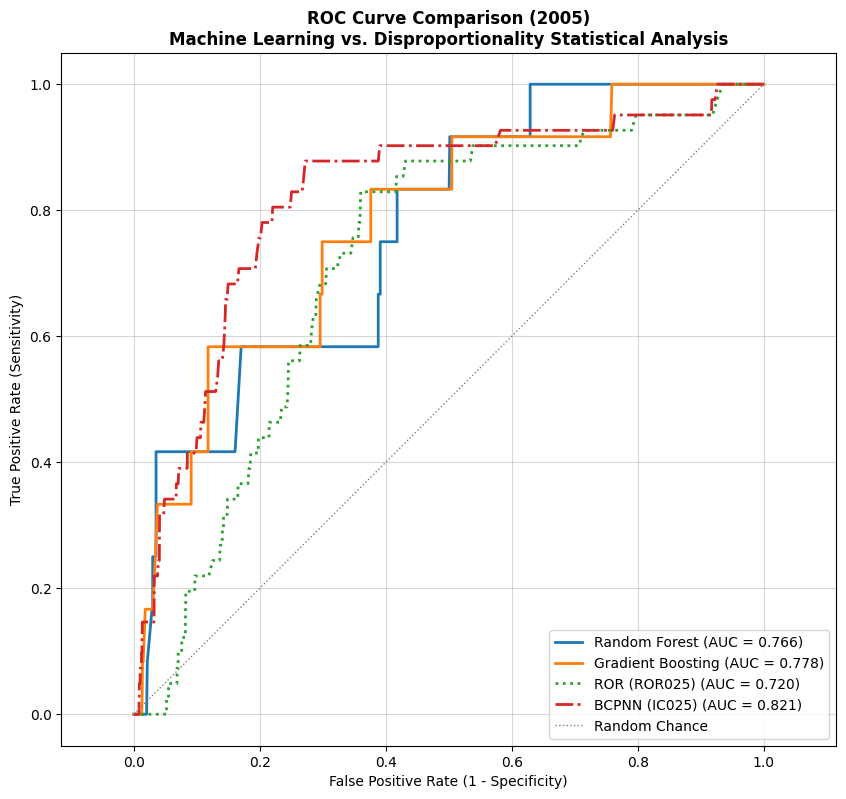

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.1292, 0.2991]
GB prediction probability range: [0.0043, 0.8149] 

RF optimal threshold: 0.2788
GB optimal threshold: 0.5954

Exported test set prediction results with 945 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.28 0.766       83.3%       58.2%
Gradient Boosting Prob ≥ 0.60 0.778       58.3%       88.2%
     ROR (ROR025)         > 1 0.720       87.8%       53.1%
    BCPNN (IC025)         > 0 0.821       87.8%       70.2%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ear

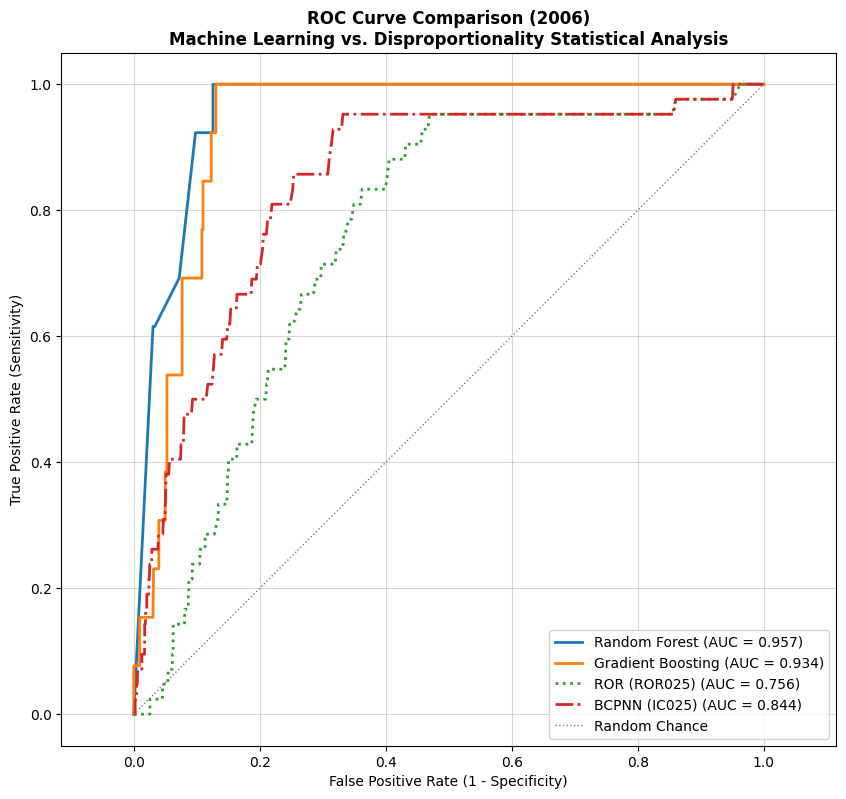

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.3264, 0.9965]
GB prediction probability range: [0.0456, 0.3852] 

RF optimal threshold: 0.8769
GB optimal threshold: 0.4187

Exported test set prediction results with 1095 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.88 0.957      100.0%       87.4%
Gradient Boosting Prob ≥ 0.42 0.934      100.0%       87.0%
     ROR (ROR025)         > 1 0.756       92.9%       53.9%
    BCPNN (IC025)         > 0 0.844       85.7%       69.2%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

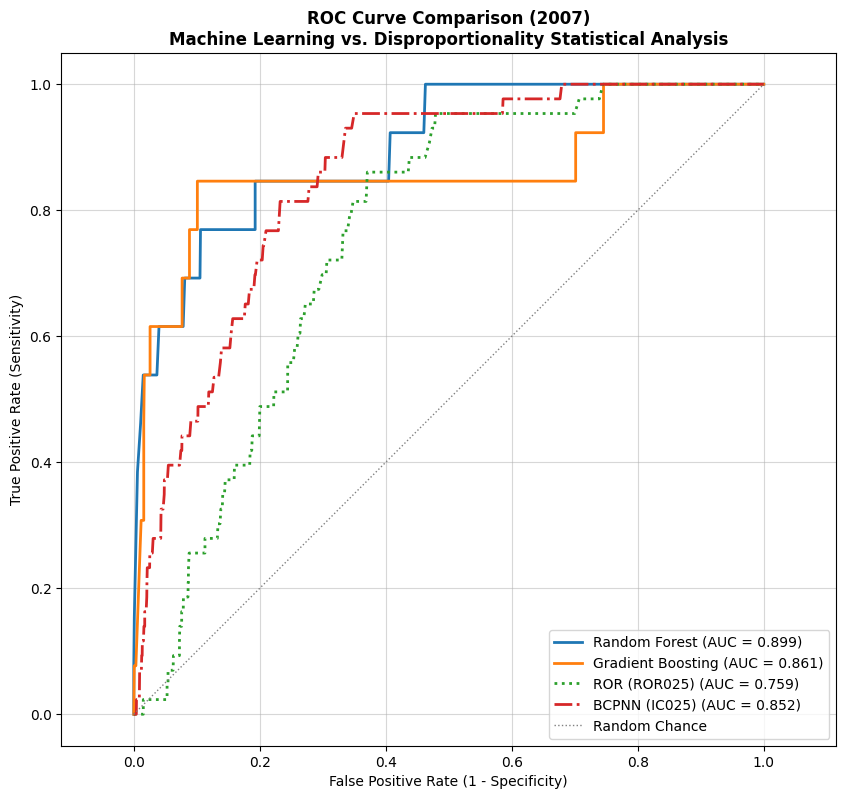

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.2191, 0.9967]
GB prediction probability range: [0.0002, 0.9840] 

RF optimal threshold: 0.9662
GB optimal threshold: 0.7468

Exported test set prediction results with 1212 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.97 0.899       76.9%       89.4%
Gradient Boosting Prob ≥ 0.75 0.861       84.6%       89.9%
     ROR (ROR025)         > 1 0.759       93.0%       52.7%
    BCPNN (IC025)         > 0 0.852       88.4%       68.0%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

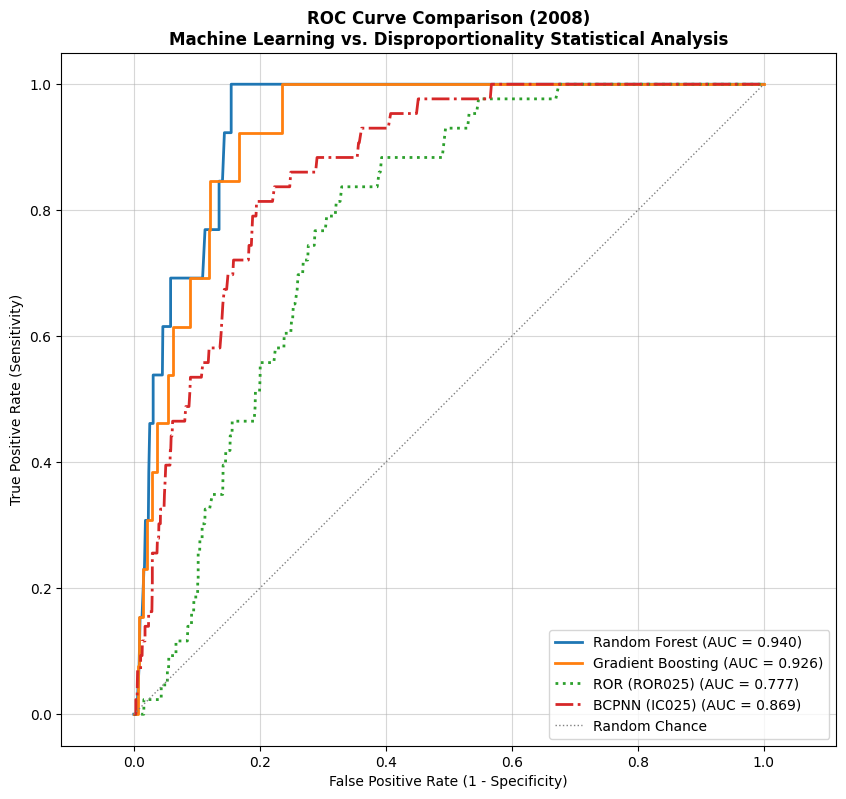

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.2890, 0.9771]
GB prediction probability range: [0.0007, 0.7555] 

RF optimal threshold: 0.9266
GB optimal threshold: 0.1052

Exported test set prediction results with 1313 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.93 0.940      100.0%       84.5%
Gradient Boosting Prob ≥ 0.11 0.926      100.0%       76.5%
     ROR (ROR025)         > 1 0.777       88.4%       53.0%
    BCPNN (IC025)         > 0 0.869       88.4%       66.9%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

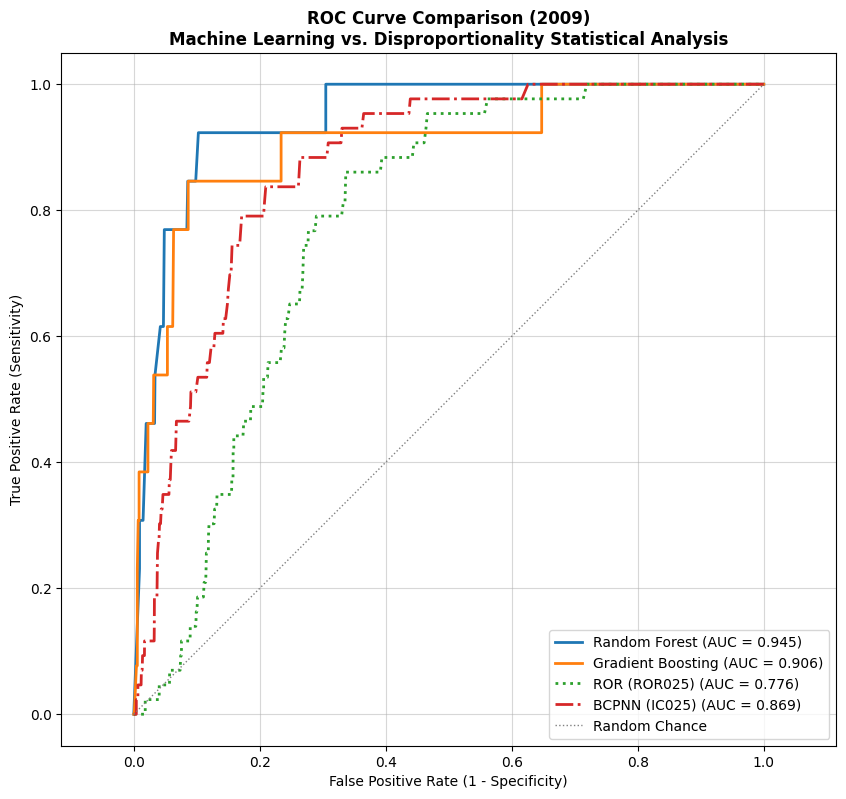

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.1893, 0.9077]
GB prediction probability range: [0.0019, 0.6401] 

RF optimal threshold: 0.9275
GB optimal threshold: 0.7017

Exported test set prediction results with 1437 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.93 0.945       92.3%       89.7%
Gradient Boosting Prob ≥ 0.70 0.906       84.6%       91.4%
     ROR (ROR025)         > 1 0.776       95.3%       52.5%
    BCPNN (IC025)         > 0 0.869       93.0%       66.1%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

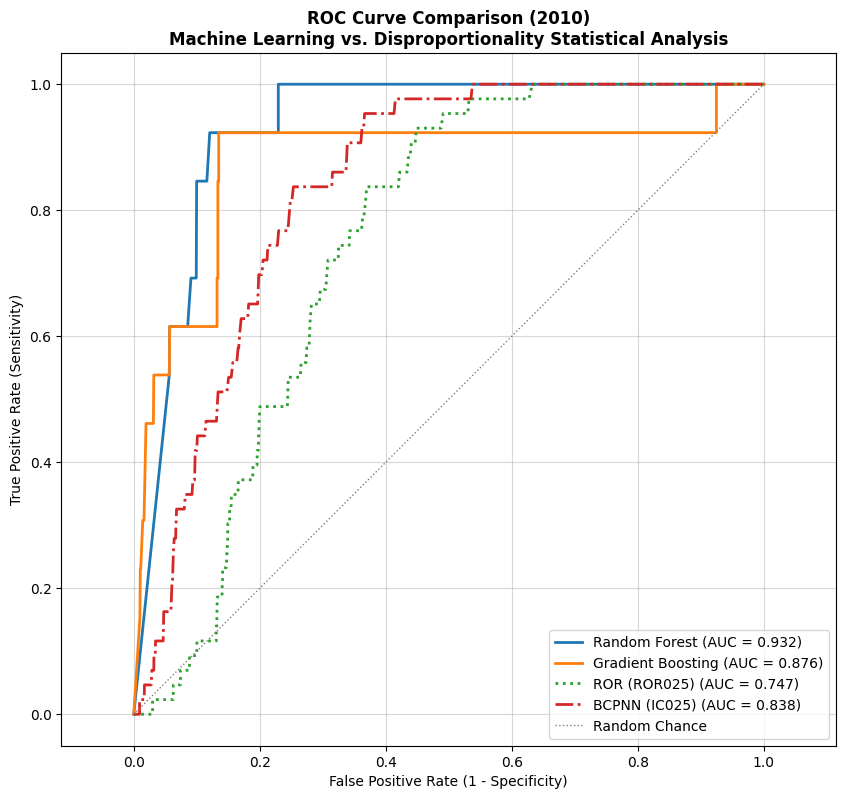

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.1995, 0.5388]
GB prediction probability range: [0.0128, 0.7306] 

RF optimal threshold: 0.7284
GB optimal threshold: 0.2307

Exported test set prediction results with 1556 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.73 0.932       92.3%       87.9%
Gradient Boosting Prob ≥ 0.23 0.876       92.3%       86.5%
     ROR (ROR025)         > 1 0.747       95.3%       48.7%
    BCPNN (IC025)         > 0 0.838       95.3%       60.7%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

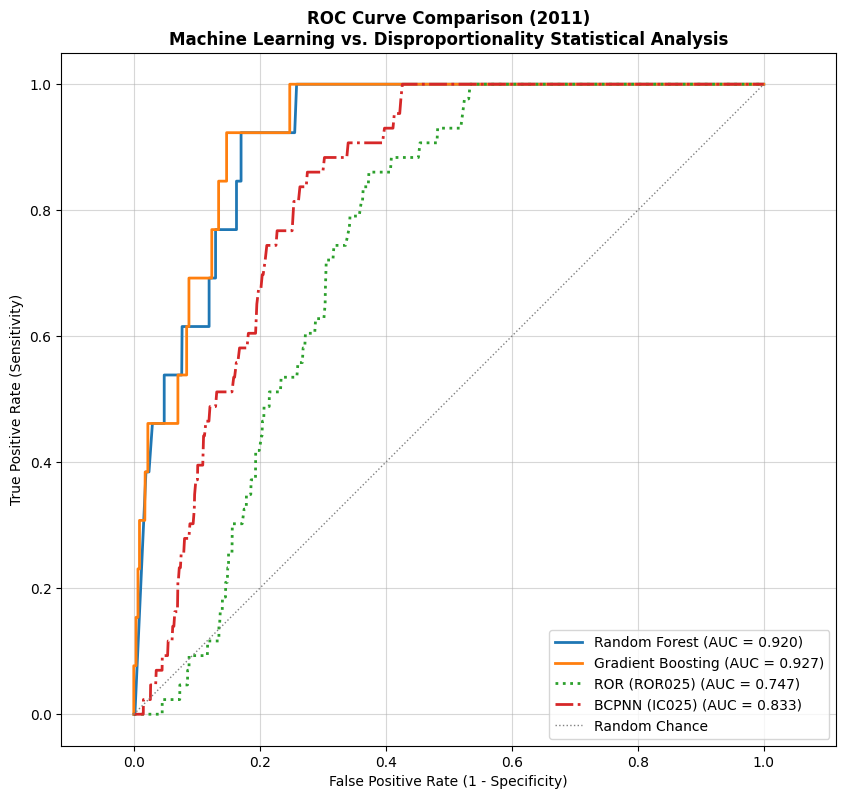

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.0997, 0.9983]
GB prediction probability range: [0.0004, 0.8123] 

RF optimal threshold: 0.4492
GB optimal threshold: 0.0940

Exported test set prediction results with 1669 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.45 0.920       92.3%       83.0%
Gradient Boosting Prob ≥ 0.09 0.927       92.3%       85.3%
     ROR (ROR025)         > 1 0.747       97.7%       47.5%
    BCPNN (IC025)         > 0 0.833       93.0%       58.9%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

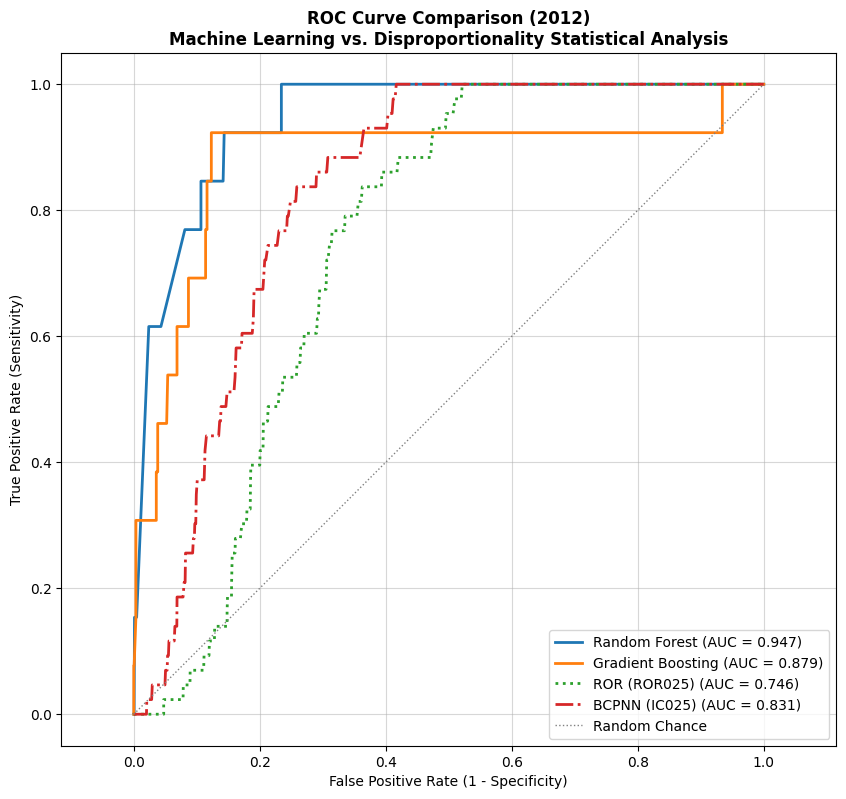

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.0100, 0.9982]
GB prediction probability range: [0.0035, 0.9587] 

RF optimal threshold: 0.5290
GB optimal threshold: 0.2000

Exported test set prediction results with 1776 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.53 0.947       92.3%       85.6%
Gradient Boosting Prob ≥ 0.20 0.879       92.3%       87.7%
     ROR (ROR025)         > 1 0.746       97.7%       48.0%
    BCPNN (IC025)         > 0 0.831       95.3%       59.2%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

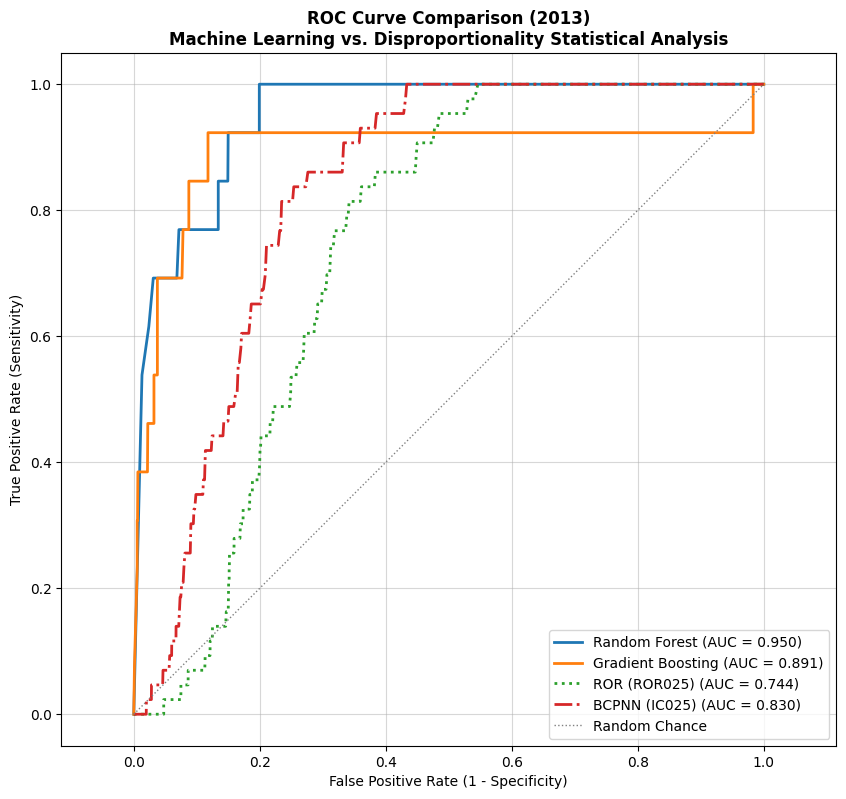

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.1896, 0.9983]
GB prediction probability range: [0.0227, 0.9826] 

RF optimal threshold: 0.2894
GB optimal threshold: 0.2404

Exported test set prediction results with 1855 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.29 0.950      100.0%       80.1%
Gradient Boosting Prob ≥ 0.24 0.891       92.3%       88.2%
     ROR (ROR025)         > 1 0.744       95.3%       48.1%
    BCPNN (IC025)         > 0 0.830       95.3%       59.5%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

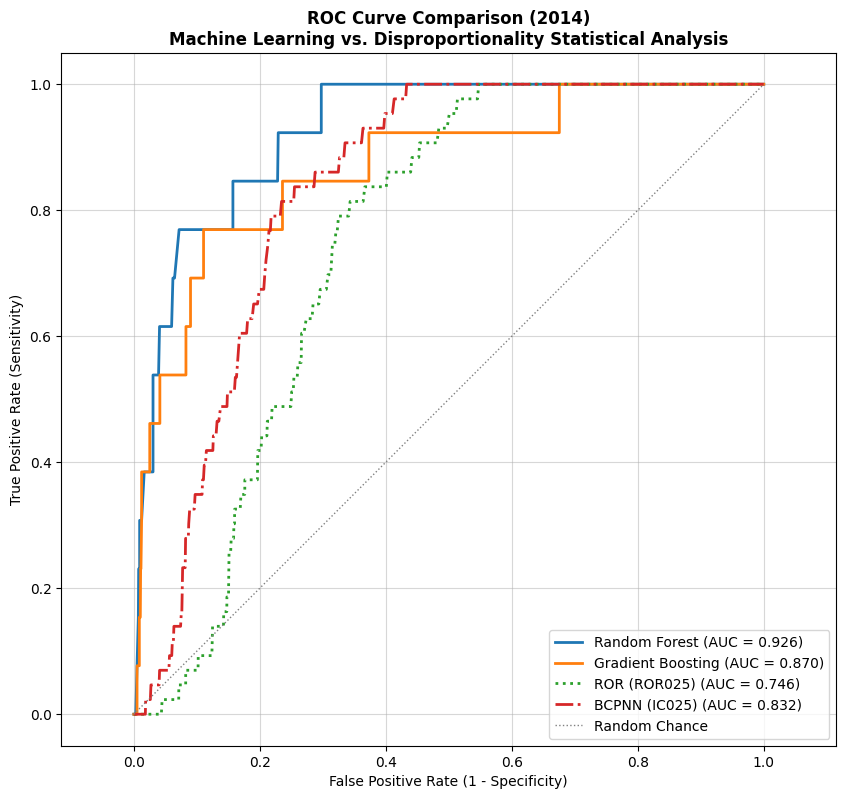

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.2495, 0.8786]
GB prediction probability range: [0.0048, 0.5053] 

RF optimal threshold: 0.0199
GB optimal threshold: 0.0744

Exported test set prediction results with 1945 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.02 0.926      100.0%       70.2%
Gradient Boosting Prob ≥ 0.07 0.870       76.9%       88.9%
     ROR (ROR025)         > 1 0.746       97.7%       48.0%
    BCPNN (IC025)         > 0 0.832       95.3%       59.9%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

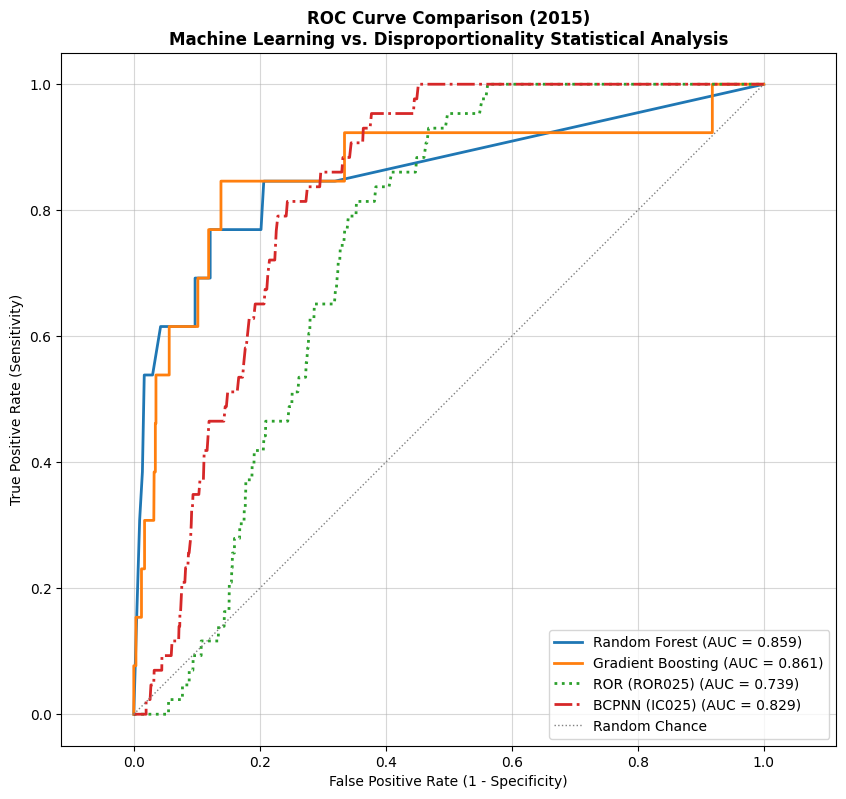

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.0000, 0.9987]
GB prediction probability range: [0.0009, 0.9362] 

RF optimal threshold: 0.4794
GB optimal threshold: 0.0249

Exported test set prediction results with 2058 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.48 0.859       76.9%       87.9%
Gradient Boosting Prob ≥ 0.02 0.861       84.6%       86.2%
     ROR (ROR025)         > 1 0.739       95.3%       47.8%
    BCPNN (IC025)         > 0 0.829       95.3%       59.7%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

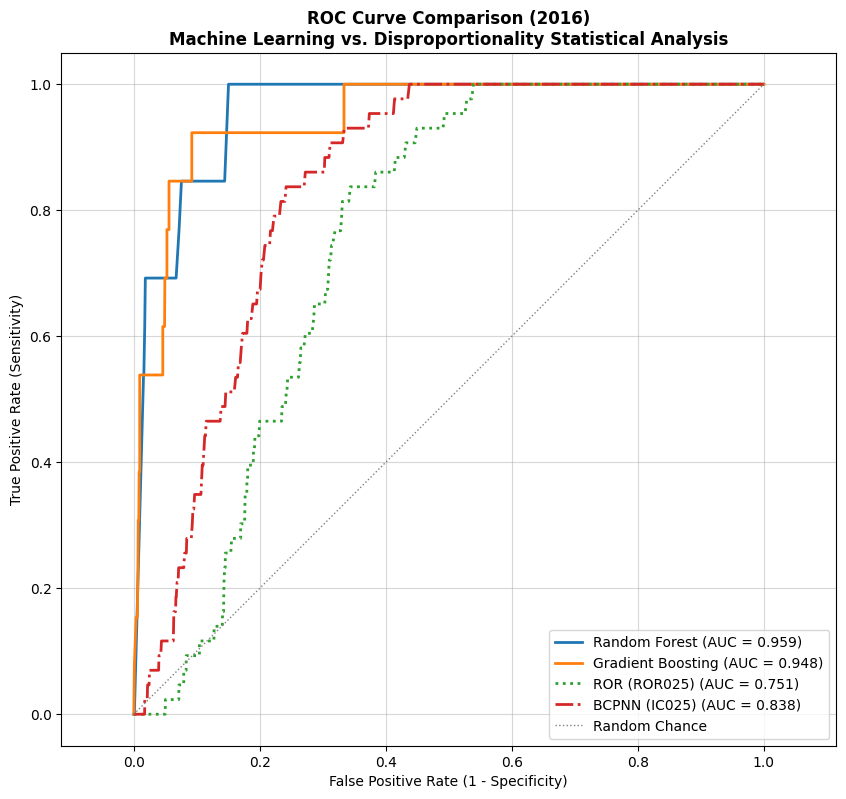

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.1697, 0.9984]
GB prediction probability range: [0.0060, 0.8632] 

RF optimal threshold: 0.4593
GB optimal threshold: 0.3760

Exported test set prediction results with 2141 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.46 0.959      100.0%       85.0%
Gradient Boosting Prob ≥ 0.38 0.948       92.3%       90.8%
     ROR (ROR025)         > 1 0.751       95.3%       48.6%
    BCPNN (IC025)         > 0 0.838       95.3%       60.4%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

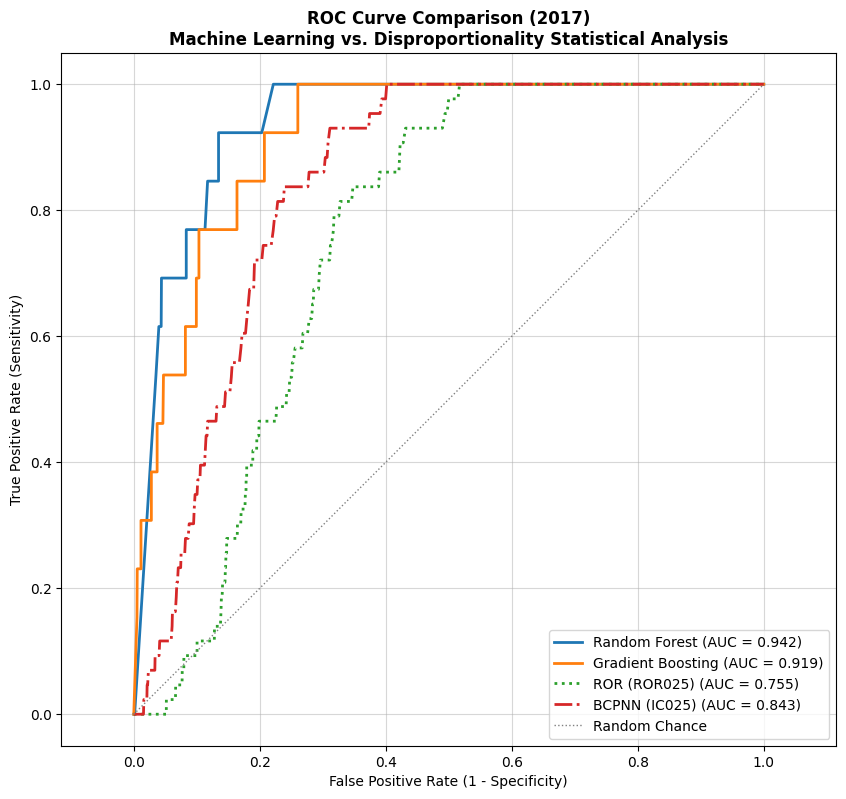

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.2197, 0.9987]
GB prediction probability range: [0.0245, 0.9644] 

RF optimal threshold: 0.4095
GB optimal threshold: 0.0131

Exported test set prediction results with 2198 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.41 0.942       92.3%       86.5%
Gradient Boosting Prob ≥ 0.01 0.919      100.0%       74.0%
     ROR (ROR025)         > 1 0.755       97.7%       48.5%
    BCPNN (IC025)         > 0 0.843       97.7%       60.4%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

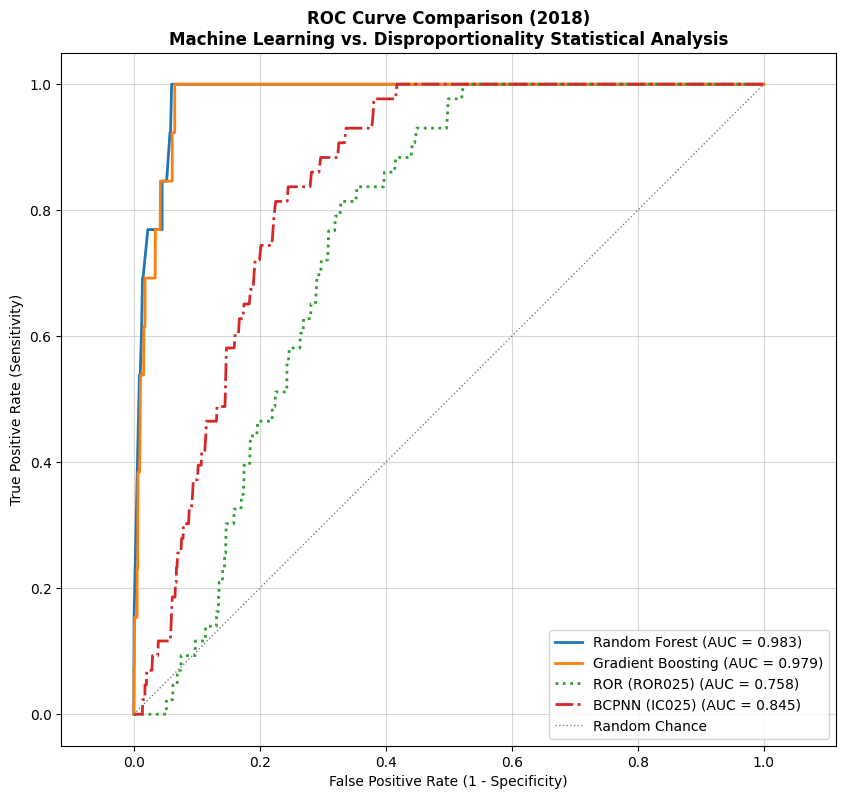

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.1896, 0.9985]
GB prediction probability range: [0.0172, 0.9974] 

RF optimal threshold: 0.9784
GB optimal threshold: 0.6506

Exported test set prediction results with 2258 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.98 0.983      100.0%       94.0%
Gradient Boosting Prob ≥ 0.65 0.979      100.0%       93.5%
     ROR (ROR025)         > 1 0.758       97.7%       48.5%
    BCPNN (IC025)         > 0 0.845       97.7%       60.1%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

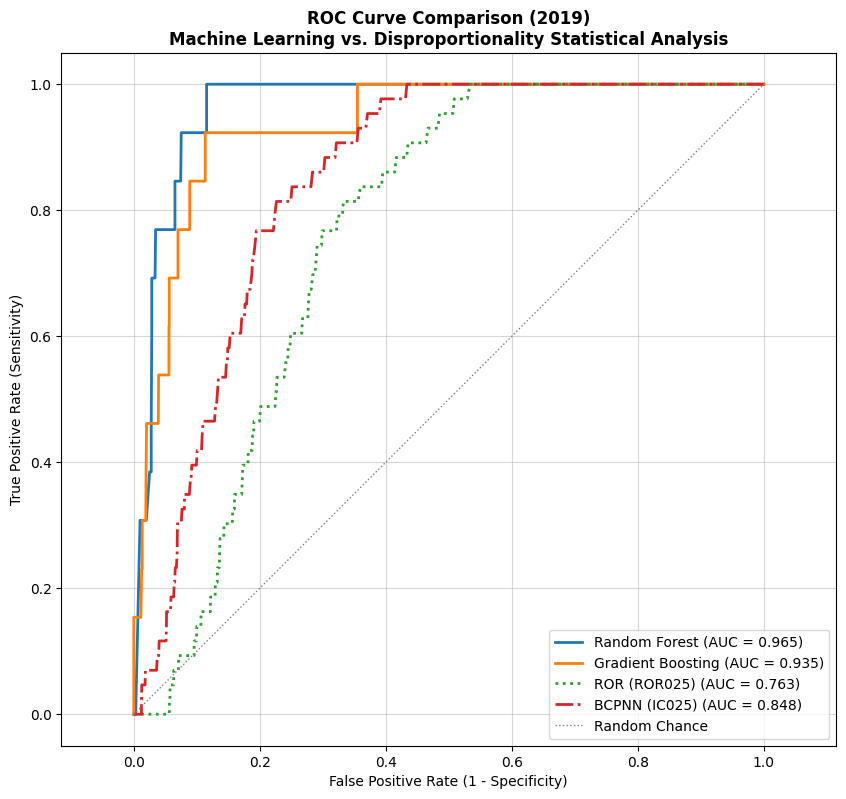

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.2096, 0.9985]
GB prediction probability range: [0.0025, 0.9663] 

RF optimal threshold: 0.5891
GB optimal threshold: 0.0652

Exported test set prediction results with 2323 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.59 0.965      100.0%       88.4%
Gradient Boosting Prob ≥ 0.07 0.935       92.3%       88.7%
     ROR (ROR025)         > 1 0.763       97.7%       48.9%
    BCPNN (IC025)         > 0 0.848       97.7%       60.5%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

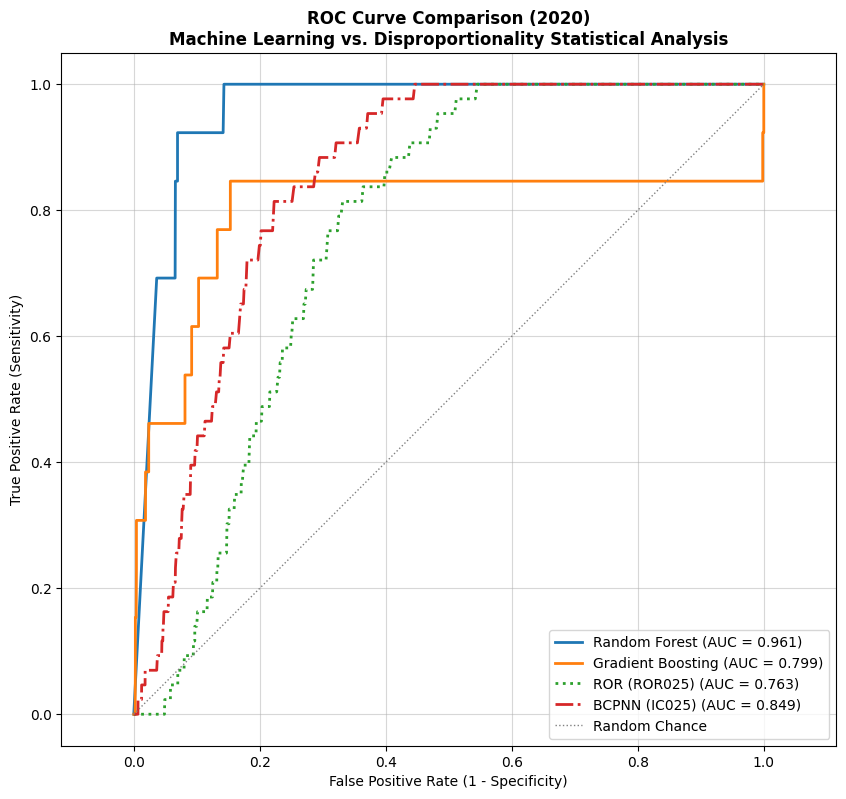

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.2296, 0.9986]
GB prediction probability range: [0.0004, 0.9921] 

RF optimal threshold: 0.3594
GB optimal threshold: 0.0474

Exported test set prediction results with 2375 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.36 0.961      100.0%       85.7%
Gradient Boosting Prob ≥ 0.05 0.799       84.6%       84.7%
     ROR (ROR025)         > 1 0.763       97.7%       48.8%
    BCPNN (IC025)         > 0 0.849       97.7%       60.4%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

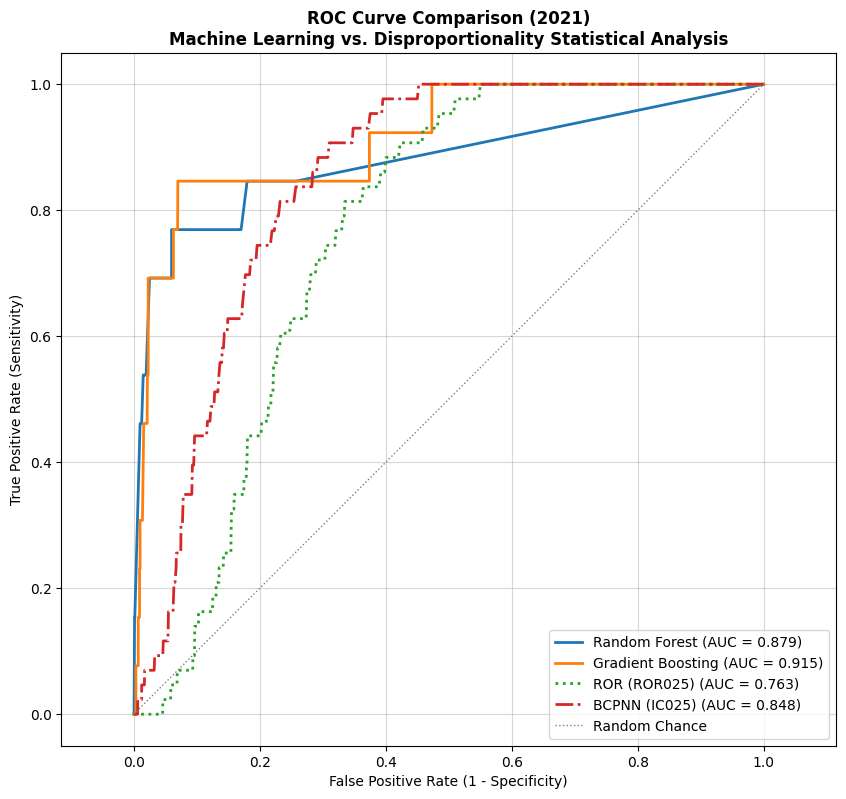

--- Prediction on Special PTs ---
Original shape of speical PT database: Quantitative Features(4, 8), Categroical Features(4, 4) 

Categorical Feature Shape After Encoding: (4, 48)
Expected Categorical Feature Dimensions: 48

Before Condendation -  Quantitative Features Shape: (4, 8), Categorical Features Shape: (4, 48)

Training Features Size: 56
Special PT Features Shape: (4, 56)

RF prediction probability range: [0.2596, 0.9989]
GB prediction probability range: [0.0070, 0.9571] 

RF optimal threshold: 0.8890
GB optimal threshold: 0.1772

Exported test set prediction results with 2414 records 

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.89 0.879       76.9%       94.0%
Gradient Boosting Prob ≥ 0.18 0.915       84.6%       93.0%
     ROR (ROR025)         > 1 0.763       97.7%       48.6%
    BCPNN (IC025)         > 0 0.848       97.7%       60.1%
Processed file: /Users/nyki/Desktop/2025/Research Project/Ea

In [ ]:
# Batch Model Training 

# Pathway to pull up file location
file_pattern = f"{base_path}/Features_Period_Report/test_04_*.xlsx"
file_paths = sorted(glob.glob(file_pattern))


for path in file_paths:
    try:
        signal_tmp_pt = pd.read_excel(path)

        print("--- Starting ML Model Evaluation ---")

        # Feature selection

        numerical_cols = ['CASE Reports', 'a', 'b', 'c', 'd', 'ror_lower_bound', 'bcpnn_lower_bound', 'sex_ratio']
        categorical_cols = ['age_group_mode', 'weight_group_mode', 'outc_cod_mode', 'soc_n']
        label_col = 'y_true'
        # Step 2.1: Define Ground Truth for PTs (if not already in signal_tmp_pt)


        signal_tmp_pt['y_true'] = signal_tmp_pt['PT'].apply(lambda pt: 1 if pt in true_signal_pts else 0)

        # Create special PT table
        special_pt_data = signal_tmp_pt[signal_tmp_pt['PT'].isin(special_pts)].copy()

        print(f"Separated special PT database : {len(special_pt_data)} records")

        # Remove special PTs from the main dataset
        signal_tmp_pt_main = signal_tmp_pt[~signal_tmp_pt['PT'].isin(special_pts)].copy()

        print(f"Remaining training database: {len(signal_tmp_pt_main)} records \n")


        # Ensure all the variables columns exist
        all_cols = numerical_cols + categorical_cols + [label_col]
        if not all(col in signal_tmp_pt.columns for col in all_cols):
             raise ValueError("DataFrame missing required columns")

        X_num = signal_tmp_pt_main[numerical_cols].copy()
        X_cat = signal_tmp_pt_main[categorical_cols].copy()
        y = signal_tmp_pt_main[label_col].copy()


        # --- 2. Data Splitting and Resampling ---
        indices = signal_tmp_pt_main.index
        train_indices, test_indices = train_test_split(indices, test_size=0.3, random_state=42, stratify=y)

        # Extract training data
        X_num_train, X_num_test = X_num.loc[train_indices], X_num.loc[test_indices]
        X_cat_train, X_cat_test = X_cat.loc[train_indices], X_cat.loc[test_indices]
        y_train, y_test = y.loc[train_indices], y.loc[test_indices]

        print(f"Initial Train Split: Train={len(y_train)}, Test={len(y_test)}")

        print(f"Initial Train Class Distribution: Positive={sum(y_train)}, Negative={len(y_train)-sum(y_train)} \n")

        positive_mask = y_train == 1
        negative_mask = y_train == 0

        # Positive signal & Negative Signal 
        pos_indices = y_train[positive_mask].index
        neg_indices = y_train[negative_mask].index

        pos_count = len(pos_indices)
        neg_count = len(neg_indices)

        print(f"Original positive samples: {pos_count}, negative samples: {neg_count}")

        # Positive:Negative ratio = 5:2
        target_neg_count = neg_count
        target_pos_count = int(target_neg_count * 20 / 1)

        print(f"Target positive samples: {target_pos_count}, negative samples: {target_neg_count}\n")

        # Resample positive PTswith replacement
        if target_pos_count > pos_count:
            # Increase positive samples size
            additional_pos_needed = target_pos_count - pos_count
            np.random.seed(42) 
            additional_pos_indices = np.random.choice(pos_indices, size=additional_pos_needed, replace=True)

            # Create new indices for training data
            resampled_pos_indices = np.concatenate([pos_indices, additional_pos_indices])
            final_train_indices = np.concatenate([resampled_pos_indices, neg_indices])
        else:
            # Random selection if there are sufficient samples 
            np.random.seed(42)
            selected_pos_indices = np.random.choice(pos_indices, size=target_pos_count, replace=False)
            final_train_indices = np.concatenate([selected_pos_indices, neg_indices])

        # Update training data
        X_num_train = X_num.loc[final_train_indices]
        X_cat_train = X_cat.loc[final_train_indices]
        y_train = y.loc[final_train_indices]


        X_num_train = X_num_train.reset_index(drop=True)
        X_cat_train = X_cat_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)

        print(f"After Resampling - Train size: {len(y_train)}\n")

        print(f"Final Train Class Distribution: Positive={sum(y_train)}, Negative={len(y_train)-sum(y_train)}")
        print(f"Ratio (Positive:Negative) = {sum(y_train)}:{len(y_train)-sum(y_train)} ≈ {sum(y_train)/(len(y_train)-sum(y_train)):.2f}:1 \n")
        
        # --- 3. Feature Preprocessing (Fit on Train, Transform Train & Test) ---

        # Imputation: missing numerical values BEFORE scaling
        # Use median strategy as it's less sensitive to outliers
        num_imputer = SimpleImputer(strategy='median')
        X_num_train = pd.DataFrame(num_imputer.fit_transform(X_num_train), columns=numerical_cols, index=X_num_train.index)
        X_num_test = pd.DataFrame(num_imputer.transform(X_num_test), columns=numerical_cols, index=X_num_test.index)
        # print("Numerical features imputed using median.")

        # Impute missing categorical values BEFORE encoding (use most frequent)
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X_cat_train = pd.DataFrame(cat_imputer.fit_transform(X_cat_train), columns=categorical_cols, index=X_cat_train.index)
        X_cat_test = pd.DataFrame(cat_imputer.transform(X_cat_test), columns=categorical_cols, index=X_cat_test.index)
        # print("Categorical features imputed using most frequent.")


        # Categorical Features：One-Hot Encoding
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        ohe.fit(X_cat_train)
        X_cat_train_encoded = ohe.transform(X_cat_train)
        X_cat_test_encoded = ohe.transform(X_cat_test)
        encoded_cat_names = ohe.get_feature_names_out(categorical_cols)
        X_cat_train_df = pd.DataFrame(X_cat_train_encoded, index=X_cat_train.index, columns=encoded_cat_names)
        X_cat_test_df = pd.DataFrame(X_cat_test_encoded, index=X_cat_test.index, columns=encoded_cat_names)
        # print(f"Categorical features encoded into {X_cat_train_df.shape[1]} columns.")

        # Quatatitives Features：Scaling (StandardScaler)
        scaler = StandardScaler()
        scaler.fit(X_num_train) # Fit on imputed numerical training data
        X_num_train_scaled = scaler.transform(X_num_train)
        X_num_test_scaled = scaler.transform(X_num_test)
        X_num_train_df = pd.DataFrame(X_num_train_scaled, index=X_num_train.index, columns=numerical_cols)
        X_num_test_df = pd.DataFrame(X_num_test_scaled, index=X_num_test.index, columns=numerical_cols)
        # print("Numerical features scaled.")

        # --- 4. Aggregate Features ---
        X_train_final = pd.concat([X_num_train_df, X_cat_train_df], axis=1)
        X_test_final = pd.concat([X_num_test_df, X_cat_test_df], axis=1)

        # --- 5. Check for NaNs after concatenation ---
        print(f"Missing values in X_train_final before fit: {X_train_final.isna().sum().sum()}")
        print(f"Missing values in X_test_final before predict: {X_test_final.isna().sum().sum()} \n")


        # For now, assume imputation worked and use original splits:
        X_train_to_use = X_train_final
        y_train_to_use = y_train
        X_test_to_use = X_test_final
        y_test_to_use = y_test


        # --- 6. Train ML Models ---
        # print("Training ML Models...")
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 5},max_depth=10,)
        gb_model = GradientBoostingClassifier(n_estimators=200,learning_rate=0.05, random_state=42)

        # Fit on imputed/cleaned data
        rf_model.fit(X_train_to_use, y_train_to_use)
        gb_model.fit(X_train_to_use, y_train_to_use) 
        # print("ML Models Trained.")

        # --- 7. Get ML Predictions and Calculate ROC/AUC ---

        # print("Calculating ML ROC data...")
        try:
            # Predict on potentially cleaned test data
            rf_probs = rf_model.predict_proba(X_test_to_use)[:, 1]
            gb_probs = gb_model.predict_proba(X_test_to_use)[:, 1]

            # Evaluate against corresponding test labels
            fpr_rf, tpr_rf, _ = roc_curve(y_test_to_use, rf_probs)
            auc_rf = auc(fpr_rf, tpr_rf)

            print(f"Random Forest AUC: {auc_rf:.4f}")

            fpr_gb, tpr_gb, _ = roc_curve(y_test_to_use, gb_probs)
            auc_gb = auc(fpr_gb, tpr_gb)

            print(f"Gradient Boosting AUC: {auc_gb:.4f}\n")
        except ValueError as e:
            print(f"ValueError during ROC calculation: {e}. Check if y_test_to_use has both classes after potential dropping.")
             # Handle error, maybe print shapes and value counts
            print("X_test_to_use shape:", X_test_to_use.shape)
            print("y_test_to_use value counts:", y_test_to_use.value_counts())

            fpr_rf, tpr_rf, auc_rf = None, None, None
            fpr_gb, tpr_gb, auc_gb = None, None, None

        except Exception as e:
            print(f"Error calculating ML ROC: {e}")
            fpr_rf, tpr_rf, auc_rf = None, None, None
            fpr_gb, tpr_gb, auc_gb = None, None, None

        
        # --- Part 2: Traditional Method Evaluation ---

        print("--- Starting Traditional Method Evaluation ---")
        # Assume 'signal_tmp_pt' DataFrame is loaded and contains PT-level scores and 'y_true'

        # Step 2.2: Validate and Prepare Traditional Data

        required_trad_cols = ['PT', 'ror_lower_bound', 'bcpnn_lower_bound', 'y_true']
        if not all(col in signal_tmp_pt.columns for col in required_trad_cols):
            raise ValueError(f"DataFrame 'signal_tmp_pt' is missing required columns: {required_trad_cols}")

        roc_data_trad = signal_tmp_pt_main[required_trad_cols].copy()
        roc_data_trad['ror_lower_bound'] = pd.to_numeric(roc_data_trad['ror_lower_bound'], errors='coerce')
        roc_data_trad['bcpnn_lower_bound'] = pd.to_numeric(roc_data_trad['bcpnn_lower_bound'], errors='coerce')
        roc_data_trad['y_true'] = pd.to_numeric(roc_data_trad['y_true'], errors='coerce').fillna(-1).astype(int)

        roc_data_trad.dropna(subset=['ror_lower_bound', 'bcpnn_lower_bound'], inplace=True)
        roc_data_trad = roc_data_trad[roc_data_trad['y_true'].isin([0, 1])]
        print(f"Using {len(roc_data_trad)} PTs with valid scores and labels for traditional ROC analysis.")

        # Step 2.3: Calculate Traditional ROC/AUC
        auc_ror, fpr_ror, tpr_ror = None, None, None
        auc_bcpnn, fpr_bcpnn, tpr_bcpnn = None, None, None

        if not roc_data_trad.empty and len(np.unique(roc_data_trad['y_true'])) >= 2:
            y_true_trad = roc_data_trad['y_true']

            # ROR
            y_score_ror = roc_data_trad['ror_lower_bound']
            if not y_score_ror.isnull().all():
                try:
                    fpr_ror, tpr_ror, _ = roc_curve(y_true_trad, y_score_ror)
                    auc_ror = auc(fpr_ror, tpr_ror)

                    print(f"ROR (ROR025) AUC: {auc_ror:.4f}")
                except ValueError as e: print(f"Could not calculate ROC for ROR: {e}")

            # BCPNN
            y_score_bcpnn = roc_data_trad['bcpnn_lower_bound']
            if not y_score_bcpnn.isnull().all():
                try:
                    fpr_bcpnn, tpr_bcpnn, _ = roc_curve(y_true_trad, y_score_bcpnn)
                    auc_bcpnn = auc(fpr_bcpnn, tpr_bcpnn)

                    print(f"BCPNN (IC025) AUC: {auc_bcpnn:.4f} \n")
                except ValueError as e: print(f"Could not calculate ROC for BCPNN: {e}")
        else:
            print("Not enough data or only one class present for traditional methods ROC.")


        # --- Part 3: Combined Plotting ---

        print("--- Plotting Combined ROC Curves ---")
        plt.figure(figsize=(10, 9)) # Make figure slightly larger

        # Extract year from filename (e.g. '05' → '2005')
        year_suffix = path.split('_')[-1].split('.')[0]
        year = f"20{year_suffix}"


        # Plot ML Models (if AUC calculated)
        if auc_rf is not None:
            plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (AUC = {auc_rf:.3f})')
        if auc_gb is not None:
            plt.plot(fpr_gb, tpr_gb, lw=2, label=f'Gradient Boosting (AUC = {auc_gb:.3f})')

        # Plot Traditional Methods (if AUC calculated)
        if auc_ror is not None:
            plt.plot(fpr_ror, tpr_ror, lw=2, linestyle=':', label=f'ROR (ROR025) (AUC = {auc_ror:.3f})')
        if auc_bcpnn is not None:
            plt.plot(fpr_bcpnn, tpr_bcpnn, lw=2, linestyle='-.', label=f'BCPNN (IC025) (AUC = {auc_bcpnn:.3f})')

        # Plot Random Chance Line (only if at least one curve exists)
        if any(auc is not None for auc in [auc_rf, auc_gb, auc_ror, auc_bcpnn]):
            plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle=':', label='Random Chance')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate (1 - Specificity)')
            plt.ylabel('True Positive Rate (Sensitivity)')
            plt.title(f"ROC Curve Comparison ({year})\n"
                        "Machine Learning vs. Disproportionality Statistical Analysis", fontsize=12, fontweight='bold')
            plt.legend(loc="lower right")
            plt.grid(alpha=0.5)
            plt.axis('equal') 
            plt.savefig(f"{base_path}/Result/ROC_20{path.split('_')[-1].split('.')[0]}.png")
            plt.show()
            

        else:
            print("No valid ROC results to plot.")

       
        # --- 8. Special PTs Prediction---

        print("--- Prediction on Special PTs ---")

        if not special_pt_data.empty:
            try:
                # Features Selection for special PTs.
                X_special_num = special_pt_data[numerical_cols].copy()
                X_special_cat = special_pt_data[categorical_cols].copy()

                print(f"Original shape of speical PT database: Quantitative Features{X_special_num.shape}, Categroical Features{X_special_cat.shape} \n")

                # Trained Imputers to process Speical PT 
                X_special_num_imputed = pd.DataFrame(
                    num_imputer.transform(X_special_num), 
                    columns=numerical_cols, 
                    index=X_special_num.index
                )
                X_special_cat_imputed = pd.DataFrame(
                    cat_imputer.transform(X_special_cat), 
                    columns=categorical_cols, 
                    index=X_special_cat.index
                )

                X_special_cat_encoded = ohe.transform(X_special_cat_imputed)
                X_special_num_scaled = scaler.transform(X_special_num_imputed)

                # Make sure the dimension matches
                print(f"Categorical Feature Shape After Encoding: {X_special_cat_encoded.shape}")
                print(f"Expected Categorical Feature Dimensions: {len(encoded_cat_names)}\n")

                # Check if dimension matches or not
                if X_special_cat_encoded.shape[1] != len(encoded_cat_names):
                    print(f"Warning！Dimensions After Encoding：{X_special_cat_encoded.shape[1]}，Required Dimensions：{len(encoded_cat_names)}")


                X_special_cat_df = pd.DataFrame(
                    X_special_cat_encoded, 
                    index=X_special_cat_imputed.index, 
                    columns=encoded_cat_names
                )
                X_special_num_df = pd.DataFrame(
                    X_special_num_scaled, 
                    index=X_special_num_imputed.index, 
                    columns=numerical_cols
                )

                # Before Aggregation
                print(f"Before Condendation -  Quantitative Features Shape: {X_special_num_df.shape}, Categorical Features Shape: {X_special_cat_df.shape}\n")
                print(f"Training Features Size: {X_train_final.shape[1]}")

                # Aggregate Features 
                X_special_final = pd.concat([X_special_num_df, X_special_cat_df], axis=1)
                print(f"Special PT Features Shape: {X_special_final.shape}\n")

                # Missing Values Check
                nan_count = X_special_final.isna().sum().sum()
                if nan_count > 0:
                    print(f"Warning! Speical PT database has {nan_count}  missing values")
                    X_special_final.fillna(0, inplace=True) 

                
                # Ensure feature order matches training
                if list(X_special_final.columns) != list(X_train_final.columns):
                    print("Warning: Feature column order mismatch, reordering...")
                    X_special_final = X_special_final.reindex(columns=X_train_final.columns, fill_value=0)

                # Use trained models for prediction
                rf_special_probs = rf_model.predict_proba(X_special_final)[:, 1]
                gb_special_probs = gb_model.predict_proba(X_special_final)[:, 1]

                print(f"RF prediction probability range: [{rf_special_probs.min():.4f}, {rf_special_probs.max():.4f}]")
                print(f"GB prediction probability range: [{gb_special_probs.min():.4f}, {gb_special_probs.max():.4f}] \n")

                # Compute standard deviation of predictions across all PTs (for d-value calculation)
                all_rf_probs = rf_model.predict_proba(X_test_to_use)[:, 1]
                all_gb_probs = gb_model.predict_proba(X_test_to_use)[:, 1]
                rf_std = np.std(all_rf_probs)
                gb_std = np.std(all_gb_probs)

                # Use Youden's J method to find optimal threshold
                def find_optimal_threshold(y_true, y_probs):
                    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
                    j_scores = tpr - fpr  # Youden's J statistic
                    ix = np.argmax(j_scores)
                    optimal_thresh = thresholds[ix]
                    # Ensure threshold is not inf/-inf if it occurs at ends
                    if optimal_thresh == np.inf:
                        optimal_thresh = thresholds[thresholds != np.inf].max()
                    elif optimal_thresh == -np.inf:
                        optimal_thresh = thresholds[thresholds != -np.inf].min()
                    return optimal_thresh

                # Get ground truth labels from test set
                test_data_original = signal_tmp_pt_main.loc[test_indices].copy()
                y_test = test_data_original['y_true']

                # Compute optimal thresholds
                rf_optimal_threshold = find_optimal_threshold(y_test, all_rf_probs)
                gb_optimal_threshold = find_optimal_threshold(y_test, all_gb_probs)

                # Assume traditional thresholds
                ror_threshold = 1  # ROR lower bound > 1 typically indicates signal
                bcpnn_threshold = 1  # BCPNN lower bound > 1 typically indicates signal

                # Create results DataFrame for special PTs
                special_results = pd.DataFrame({
                    'PT': special_pt_data['PT'],
                    'RF_Prediction': rf_special_probs,
                    'GB_Prediction': gb_special_probs,
                    'ROR_Lower_Bound': special_pt_data['ror_lower_bound'],
                    'BCPNN_Lower_Bound': special_pt_data['bcpnn_lower_bound'],
                    'RF_d_value': (rf_special_probs - rf_optimal_threshold) / rf_std,
                    'GB_d_value': (gb_special_probs - gb_optimal_threshold) / gb_std,
                    'ROR_d_value': (special_pt_data['ror_lower_bound'] - ror_threshold) / np.std(signal_tmp_pt_main['ror_lower_bound']),
                    'BCPNN_d_value': (special_pt_data['bcpnn_lower_bound'] - bcpnn_threshold) / np.std(signal_tmp_pt_main['bcpnn_lower_bound'])
                })

                # Create test set results DataFrame
                test_results = pd.DataFrame({
                    'PT': test_data_original['PT'],
                    'RF_Prediction': all_rf_probs,
                    'GB_Prediction': all_gb_probs,
                    'ROR_Lower_Bound': test_data_original['ror_lower_bound'],
                    'BCPNN_Lower_Bound': test_data_original['bcpnn_lower_bound'],
                    'y_true': test_data_original['y_true'],
                    'RF_d_value': (all_rf_probs - rf_optimal_threshold) / rf_std,
                    'GB_d_value': (all_gb_probs - gb_optimal_threshold) / gb_std,
                    'ROR_d_value': (test_data_original['ror_lower_bound'] - ror_threshold) / np.std(signal_tmp_pt_main['ror_lower_bound']),
                    'BCPNN_d_value': (test_data_original['bcpnn_lower_bound'] - bcpnn_threshold) / np.std(signal_tmp_pt_main['bcpnn_lower_bound'])
                })

                # Print threshold info
                print(f"RF optimal threshold: {rf_optimal_threshold:.4f}")
                print(f"GB optimal threshold: {gb_optimal_threshold:.4f}\n")

                # After assembling special_results and test_results DataFrames (with original d-values):
                special_results = recompute_d_values(special_results, pt_col = 'PT')
                test_results = recompute_d_values(test_results, pt_col = 'PT')

                # Export results
                filename_prefix = path.split('_')[-1].split('.')[0]
                special_results.to_excel(f"{base_path}/Result/Special_PT_{filename_prefix}.xlsx", index=False)
                test_results.to_excel(f"{base_path}/Result/Test_Set_{filename_prefix}.xlsx", index=False)

                print(f"Exported test set prediction results with {len(test_results)} records \n")

            except Exception as e:
                print(f"Error with Special PTs: {e}")
                import traceback
                traceback.print_exc()
        else:
            print('Could not find special PTs data')  
            

        def log(msg, sep_before=False, sep_after=False):
            if sep_before:
                print("\n" + "="*60)
            print(msg)
            if sep_after:
                print("="*60 + "\n")
            

        # --- Begin generating performance table ---

        # print("--- Generating Performance Metrics Table ---")

        performance_data = []

        # Function to find optimal threshold using Youden's J
        def find_optimal_threshold(y_true, y_probs):
            fpr, tpr, thresholds = roc_curve(y_true, y_probs)
            j_scores = tpr - fpr
            ix = np.argmax(j_scores)
            optimal_thresh = thresholds[ix]
            if optimal_thresh == np.inf:
                optimal_thresh = thresholds[thresholds != np.inf].max()
            elif optimal_thresh == -np.inf:
                optimal_thresh = thresholds[thresholds != -np.inf].min()
            sensitivity = tpr[ix]
            specificity = 1.0 - fpr[ix]
            return optimal_thresh, sensitivity, specificity

        # Random Forest
        if auc_rf is not None:

            # print("Calculating RF optimal threshold...")
            try:
                rf_thresh, rf_sens, rf_spec = find_optimal_threshold(y_test, rf_probs)
                performance_data.append({
                    'Method': 'Random Forest',
                    'Threshold': f'Prob ≥ {rf_thresh:.2f}',
                    'AUROC': f"{auc_rf:.3f}",
                    'Sensitivity': f"{rf_sens:.1%}",
                    'Specificity': f"{rf_spec:.1%}"
                })
            except Exception as e:
                print(f"Error calculating RF metrics: {e}")
                performance_data.append({'Method': 'Random Forest', 'AUROC': f"{auc_rf:.3f}", 'Threshold': 'N/A', 'Sensitivity': 'N/A', 'Specificity': 'N/A'})

        # Gradient Boosting
        if auc_gb is not None:

            # print("Calculating GB optimal threshold...")
            try:
                gb_thresh, gb_sens, gb_spec = find_optimal_threshold(y_test, gb_probs)
                performance_data.append({
                    'Method': 'Gradient Boosting',
                    'Threshold': f'Prob ≥ {gb_thresh:.2f}',
                    'AUROC': f"{auc_gb:.3f}",
                    'Sensitivity': f"{gb_sens:.1%}",
                    'Specificity': f"{gb_spec:.1%}"
                })
            except Exception as e:
                print(f"Error calculating GB metrics: {e}")
                performance_data.append({'Method': 'Gradient Boosting', 'AUROC': f"{auc_gb:.3f}", 'Threshold': 'N/A', 'Sensitivity': 'N/A', 'Specificity': 'N/A'})

        # Traditional method metrics
        def calculate_metrics_at_threshold(y_true, y_score, threshold):
            if y_score is None or y_true is None or len(y_true) == 0:
                return 'N/A', 'N/A'
            try:
                y_pred_binary = (y_score > threshold).astype(int)
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                return sensitivity, specificity
            except Exception as e:
                print(f"Error calculating confusion matrix metrics: {e}")
                return 'N/A', 'N/A'

        # ROR
        if auc_ror is not None:

            # print("Calculating ROR metrics at Threshold > 1...")
            y_true_trad = roc_data_trad['y_true']
            y_score_ror = roc_data_trad['ror_lower_bound']
            ror_sens, ror_spec = calculate_metrics_at_threshold(y_true_trad, y_score_ror, threshold=1)
            performance_data.append({
                'Method': 'ROR (ROR025)',
                'Threshold': '> 1',
                'AUROC': f"{auc_ror:.3f}",
                'Sensitivity': f"{ror_sens:.1%}" if isinstance(ror_sens, (int, float)) else ror_sens,
                'Specificity': f"{ror_spec:.1%}" if isinstance(ror_spec, (int, float)) else ror_spec
            })

        # BCPNN
        if auc_bcpnn is not None:

            # print("Calculating BCPNN metrics at Threshold > 1...")
            y_true_trad = roc_data_trad['y_true']
            y_score_bcpnn = roc_data_trad['bcpnn_lower_bound']
            bcpnn_sens, bcpnn_spec = calculate_metrics_at_threshold(y_true_trad, y_score_bcpnn, threshold=0)
            performance_data.append({
                'Method': 'BCPNN (IC025)',
                'Threshold': '> 1',
                'AUROC': f"{auc_bcpnn:.3f}",
                'Sensitivity': f"{bcpnn_sens:.1%}" if isinstance(bcpnn_sens, (int, float)) else bcpnn_sens,
                'Specificity': f"{bcpnn_spec:.1%}" if isinstance(bcpnn_spec, (int, float)) else bcpnn_spec
            })

        # Final performance table
        if performance_data:
            performance_df = pd.DataFrame(performance_data)
            performance_df = performance_df[['Method', 'Threshold', 'AUROC', 'Sensitivity', 'Specificity']]
            print("--- Performance Metrics Summary ---")
            print(performance_df.to_string(index=False))
            performance_df.to_excel(f"{base_path}/Result/Performance_Metrics_20{path.split('_')[-1].split('.')[0]}.xlsx", index=False)
        else:
            print("Could not generate performance metrics table.")
        print(f"Processed file: {path}")

    except Exception as e:
        print(f"Error with propcessing this file {path}: {e}")    

##### Overall Performance Preview

In [ ]:
import os
import glob

pattern = os.path.join(base_path, "Result", "Performance_Metrics_20*.xlsx")
files = sorted(glob.glob(pattern))

df_list = []
for file in files:
    df = pd.read_excel(file)
    year_str = os.path.basename(file).split('_')[-1].split('.')[0]
    year = int(year_str)
    df['Year'] = year
    df_list.append(df)

# Concatenate all into a master DataFrame
master_perf = pd.concat(df_list, ignore_index=True)

# Save to Excel
master_perf.to_excel(f'{base_path}/SignalSummarise/Performance_Metrics_2005-2021.xlsx', index=False)
master_perf

,Method,Threshold,AUROC,Sensitivity,Specificity,Year
0,Random Forest,Prob ≥ 0.28,0.766,83.3%,58.2%,2005
1,Gradient Boosting,Prob ≥ 0.60,0.778,58.3%,88.2%,2005
2,ROR (ROR025),> 1,0.720,87.8%,53.1%,2005
3,BCPNN (IC025),> 0,0.821,87.8%,70.2%,2005
4,Random Forest,Prob ≥ 0.88,0.957,100.0%,87.4%,2006
...,...,...,...,...,...,...
63,BCPNN (IC025),> 0,0.849,97.7%,60.4%,2020
64,Random Forest,Prob ≥ 0.89,0.879,76.9%,94.0%,2021
65,Gradient Boosting,Prob ≥ 0.18,0.915,84.6%,93.0%,2021
66,ROR (ROR025),> 1,0.763,97.7%,48.6%,2021


Output: 
- Restul/Special_PT_* | Special PT d_values
- Result/Test_Set_* | All other relevant PT d_values
- Result/Performance_Metrics_20* | To draw ROC plot


Input: Result/Special_PT_*
Output: YearlyBasedPerformance/PT.xlsx
        YearlyBasedPerformance/PT.pgn
        FilteredYearlyBasedPerformance/PT.xlsx
        FilteredYearlyBasedPerformance/PT.png


In [ ]:
# Non-Transformed_D_value
# Aggregate yearly data for four PTs:
import pandas as pd
import glob
import os
import re

def process_special_pt_files():
    # Use glob to get all Special_PT files
    file_pattern = f"{base_path}/Result/Special_PT_*.xlsx"
    files = glob.glob(file_pattern)
    
    # Sort by the numeric identifier in filename
    files.sort(key=lambda x: int(re.findall(r'Special_PT_(\d+)', x)[0]))
    
    # Four PT types
    pt_types = [
        'ELECTROCARDIOGRAM QT PROLONGED',
        'SEROTONIN SYNDROME', 
        'SEXUAL DYSFUNCTION',
        'ANGLE CLOSURE GLAUCOMA'
    ]
    
    # Initialize storage for each PT
    pt_data = {pt: [] for pt in pt_types}
    
    # Process each file
    for file in files:
        # Extract year number from filename
        year_num = int(re.findall(r'Special_PT_(\d+)', file)[0])
        
        try:
            # Read Excel file
            df = pd.read_excel(file)
            
            # Collect data for each PT
            for pt in pt_types:
                if pt in df['PT'].values:
                    # Get the row corresponding to this PT
                    pt_row = df[df['PT'] == pt].iloc[0]
                    
                    # Build row with year information
                    row_data = {
                        'Year': year_num,
                        'PT': pt,
                        'RF_Prediction': pt_row['RF_Prediction'],
                        'GB_Prediction': pt_row['GB_Prediction'],
                        'ROR_Lower_Bound': pt_row['ROR_Lower_Bound'],
                        'BCPNN_Lower_Bound': pt_row['BCPNN_Lower_Bound'],
                        'RF_d_value': pt_row['RF_d_value'],
                        'GB_d_value': pt_row['GB_d_value'],
                        'ROR_d_value': pt_row['ROR_d_value'],
                        'BCPNN_d_value': pt_row['BCPNN_d_value']
                    }
                    pt_data[pt].append(row_data)
                else:
                    # If this PT is missing in a given year, append empty row
                    row_data = {
                        'Year': year_num,
                        'PT': pt,
                        'RF_Prediction': None,
                        'GB_Prediction': None,
                        'ROR_Lower_Bound': None,
                        'BCPNN_Lower_Bound': None,
                        'RF_d_value': None,
                        'GB_d_value': None,
                        'ROR_d_value': None,
                        'BCPNN_d_value': None
                    }
                    pt_data[pt].append(row_data)
                    
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    
    # Build DataFrame per PT and save
    for pt in pt_types:
        if pt_data[pt]:  
            df_pt = pd.DataFrame(pt_data[pt])
            df_pt = df_pt.sort_values('Year')  # sort by year
            
            # Create safe filename (replace problematic chars)
            safe_filename = pt.replace(' ', '_').replace('/', '_')
            output_file = f"{base_path}/YearlyBasedPerformance/{safe_filename}.xlsx"
            
            # Save to Excel
            df_pt.to_excel(output_file, index=False)
            print(f"Saved yearly data for {pt} to: {output_file}")
            print(f"Data shape: {df_pt.shape}")
            print(f"Year range: {df_pt['Year'].min()} - {df_pt['Year'].max()}")
            print("-" * 50)
    
    return pt_data

# Execute if run as script
if __name__ == "__main__":
    # Ensure output directory exists
    os.makedirs(f"{base_path}/Result/YearlyBasedPerformance", exist_ok=True)
    
    # Process files
    result_data = process_special_pt_files()
    
    # Print summary statistics
    print("\n=== Processing Complete ===")
    for pt, data in result_data.items():
        print(f"{pt}: {len(data)} years of data")



Saved yearly data for ELECTROCARDIOGRAM QT PROLONGED to: /Users/nyki/Desktop/2025/Research Project/EarlySignalDetection/YearlyBasedPerformance/ELECTROCARDIOGRAM_QT_PROLONGED.xlsx
Data shape: (17, 10)
Year range: 5 - 21
--------------------------------------------------
Saved yearly data for SEROTONIN SYNDROME to: /Users/nyki/Desktop/2025/Research Project/EarlySignalDetection/YearlyBasedPerformance/SEROTONIN_SYNDROME.xlsx
Data shape: (17, 10)
Year range: 5 - 21
--------------------------------------------------
Saved yearly data for SEXUAL DYSFUNCTION to: /Users/nyki/Desktop/2025/Research Project/EarlySignalDetection/YearlyBasedPerformance/SEXUAL_DYSFUNCTION.xlsx
Data shape: (17, 10)
Year range: 5 - 21
--------------------------------------------------
Saved yearly data for ANGLE CLOSURE GLAUCOMA to: /Users/nyki/Desktop/2025/Research Project/EarlySignalDetection/YearlyBasedPerformance/ANGLE_CLOSURE_GLAUCOMA.xlsx
Data shape: (17, 10)
Year range: 5 - 21
-----------------------------------

##### Special PT Performance Overview & Visualizations

In [123]:
import pandas as pd
import glob
import os
import re

def process_special_pt_files():
    # Use glob to get all Special_PT files
    file_pattern = f"{base_path}/Result/Special_PT_*.xlsx"
    files = glob.glob(file_pattern)
    
    # Sort by the numeric identifier in filename
    files.sort(key=lambda x: int(re.findall(r'Special_PT_(\d+)', x)[0]))
    
    # Four PT types
    pt_types = [
        'ELECTROCARDIOGRAM QT PROLONGED',
        'SEROTONIN SYNDROME', 
        'SEXUAL DYSFUNCTION',
        'ANGLE CLOSURE GLAUCOMA'
    ]
    
    # Initialize storage for each PT
    pt_data = {pt: [] for pt in pt_types}
    
    # Process each file
    for file in files:
        # Extract year number from filename
        year_num = int(re.findall(r'Special_PT_(\d+)', file)[0])
        
        try:
            # Read Excel file
            df = pd.read_excel(file)
            
            # Collect data for each PT
            for pt in pt_types:
                if pt in df['PT'].values:
                    # Get the row corresponding to this PT
                    pt_row = df[df['PT'] == pt].iloc[0]
                    
                    # Build row with year information, including transformed d-values and y_true if present
                    row_data = {
                        'Year': year_num,
                        'PT': pt,
                        'RF_Prediction': pt_row.get('RF_Prediction', None),
                        'GB_Prediction': pt_row.get('GB_Prediction', None),
                        'ROR_Lower_Bound': pt_row.get('ROR_Lower_Bound', None),
                        'BCPNN_Lower_Bound': pt_row.get('BCPNN_Lower_Bound', None),
                        'RF_d_value_transformed': pt_row.get('RF_d_value_transformed', None),
                        'GB_d_value_transformed': pt_row.get('GB_d_value_transformed', None),
                        'ROR_d_value_transformed': pt_row.get('ROR_d_value_transformed', None),
                        'BCPNN_d_value_transformed': pt_row.get('BCPNN_d_value_transformed', None),
                        'y_true': pt_row.get('y_true', None)
                    }
                    pt_data[pt].append(row_data)
                else:
                    # If this PT is missing in a given year, append empty row
                    row_data = {
                        'Year': year_num,
                        'PT': pt,
                        'RF_Prediction': None,
                        'GB_Prediction': None,
                        'ROR_Lower_Bound': None,
                        'BCPNN_Lower_Bound': None,
                        'RF_d_value_transformed': None,
                        'GB_d_value_transformed': None,
                        'ROR_d_value_transformed': None,
                        'BCPNN_d_value_transformed': None,
                        'y_true': None
                    }
                    pt_data[pt].append(row_data)
                    
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    
    # Build DataFrame per PT and save
    for pt in pt_types:
        if pt_data[pt]:
            df_pt = pd.DataFrame(pt_data[pt])
            df_pt = df_pt.sort_values('Year')  # sort by year
            
            # Create safe filename (replace problematic chars)
            safe_filename = pt.replace(' ', '_').replace('/', '_')
            output_file = f"{base_path}/YearlyBasedPerformance/{safe_filename}.xlsx"
            
            # Save to Excel
            df_pt.to_excel(output_file, index=False)
            print(f"Saved yearly data for {pt} to: {output_file}")
            print(f"Data shape: {df_pt.shape}")
            print(f"Year range: {df_pt['Year'].min()} - {df_pt['Year'].max()}")
            print("-" * 50)
    
    return pt_data

# Execute if run as script
if __name__ == "__main__":
    # Ensure output directory exists
    os.makedirs(f"{base_path}/YearlyBasedPerformance", exist_ok=True)
    
    # Process files
    result_data = process_special_pt_files()
    
    # Print summary statistics
    print("\n=== Processing Complete ===")
    for pt, data in result_data.items():
        print(f"{pt}: {len(data)} years of data")


Saved yearly data for ELECTROCARDIOGRAM QT PROLONGED to: /Users/nyki/Desktop/2025/Research Project/EarlySignalDetection/YearlyBasedPerformance/ELECTROCARDIOGRAM_QT_PROLONGED.xlsx
Data shape: (17, 11)
Year range: 5 - 21
--------------------------------------------------
Saved yearly data for SEROTONIN SYNDROME to: /Users/nyki/Desktop/2025/Research Project/EarlySignalDetection/YearlyBasedPerformance/SEROTONIN_SYNDROME.xlsx
Data shape: (17, 11)
Year range: 5 - 21
--------------------------------------------------
Saved yearly data for SEXUAL DYSFUNCTION to: /Users/nyki/Desktop/2025/Research Project/EarlySignalDetection/YearlyBasedPerformance/SEXUAL_DYSFUNCTION.xlsx
Data shape: (17, 11)
Year range: 5 - 21
--------------------------------------------------
Saved yearly data for ANGLE CLOSURE GLAUCOMA to: /Users/nyki/Desktop/2025/Research Project/EarlySignalDetection/YearlyBasedPerformance/ANGLE_CLOSURE_GLAUCOMA.xlsx
Data shape: (17, 11)
Year range: 5 - 21
-----------------------------------

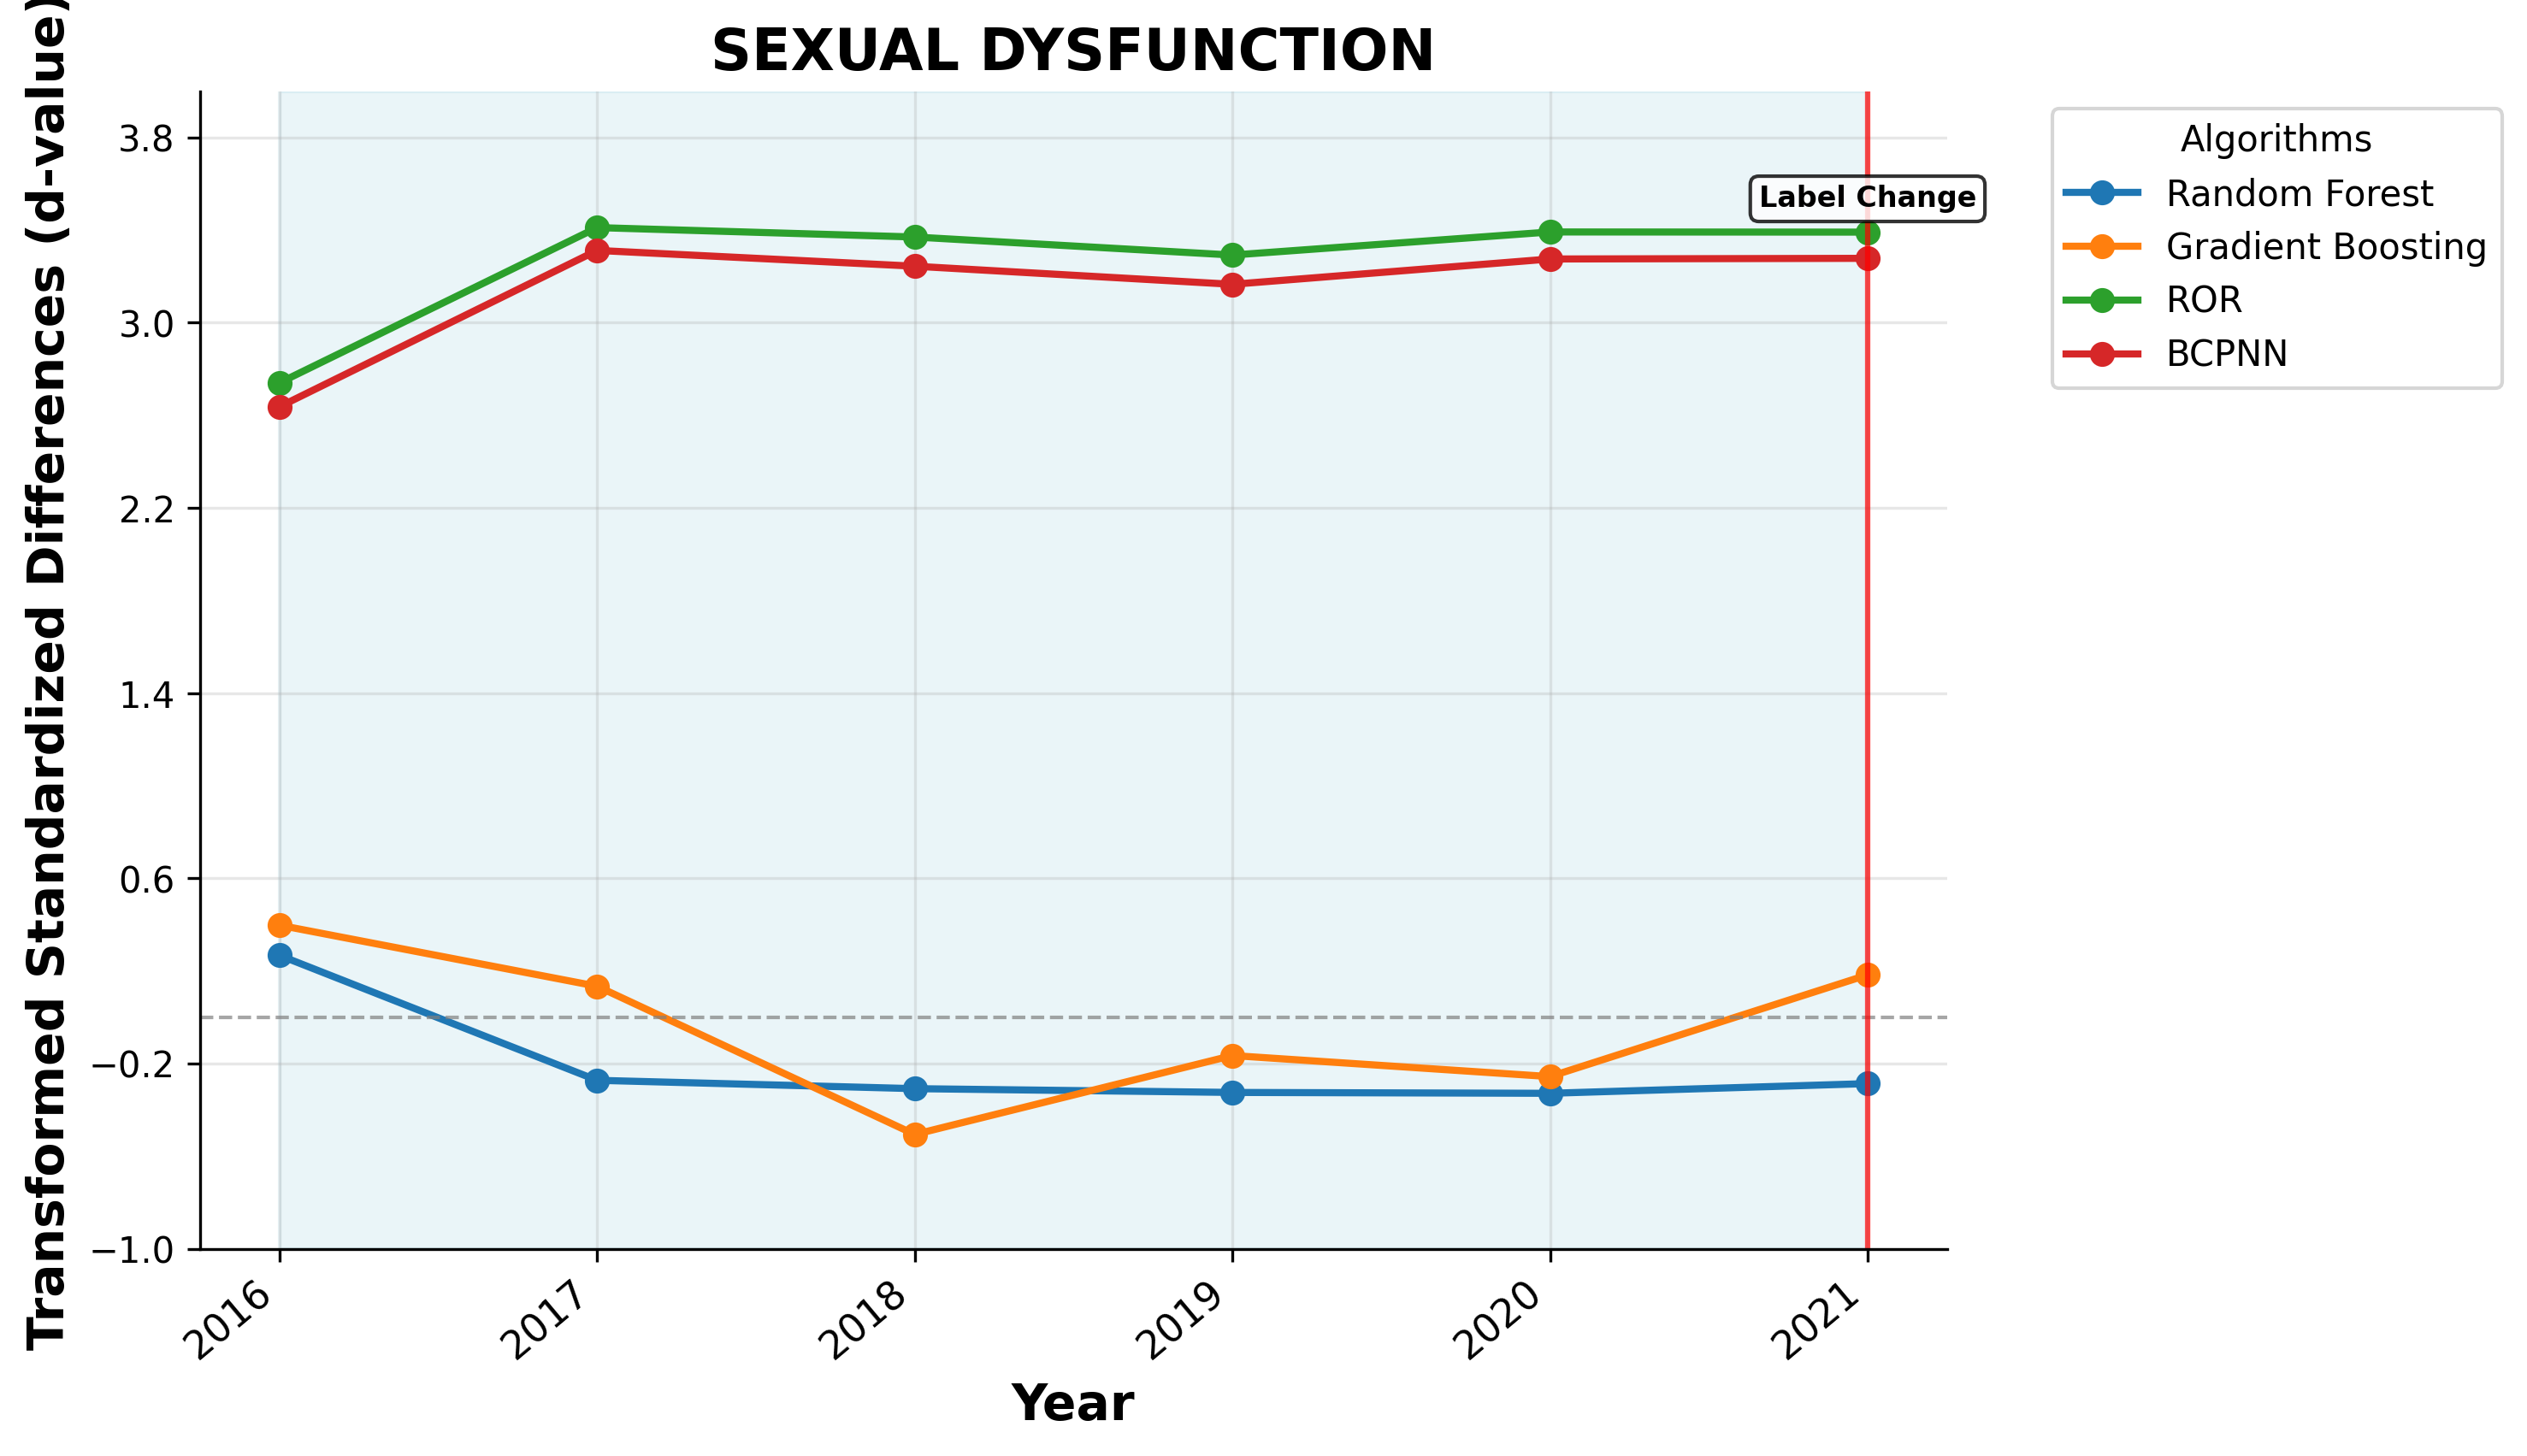

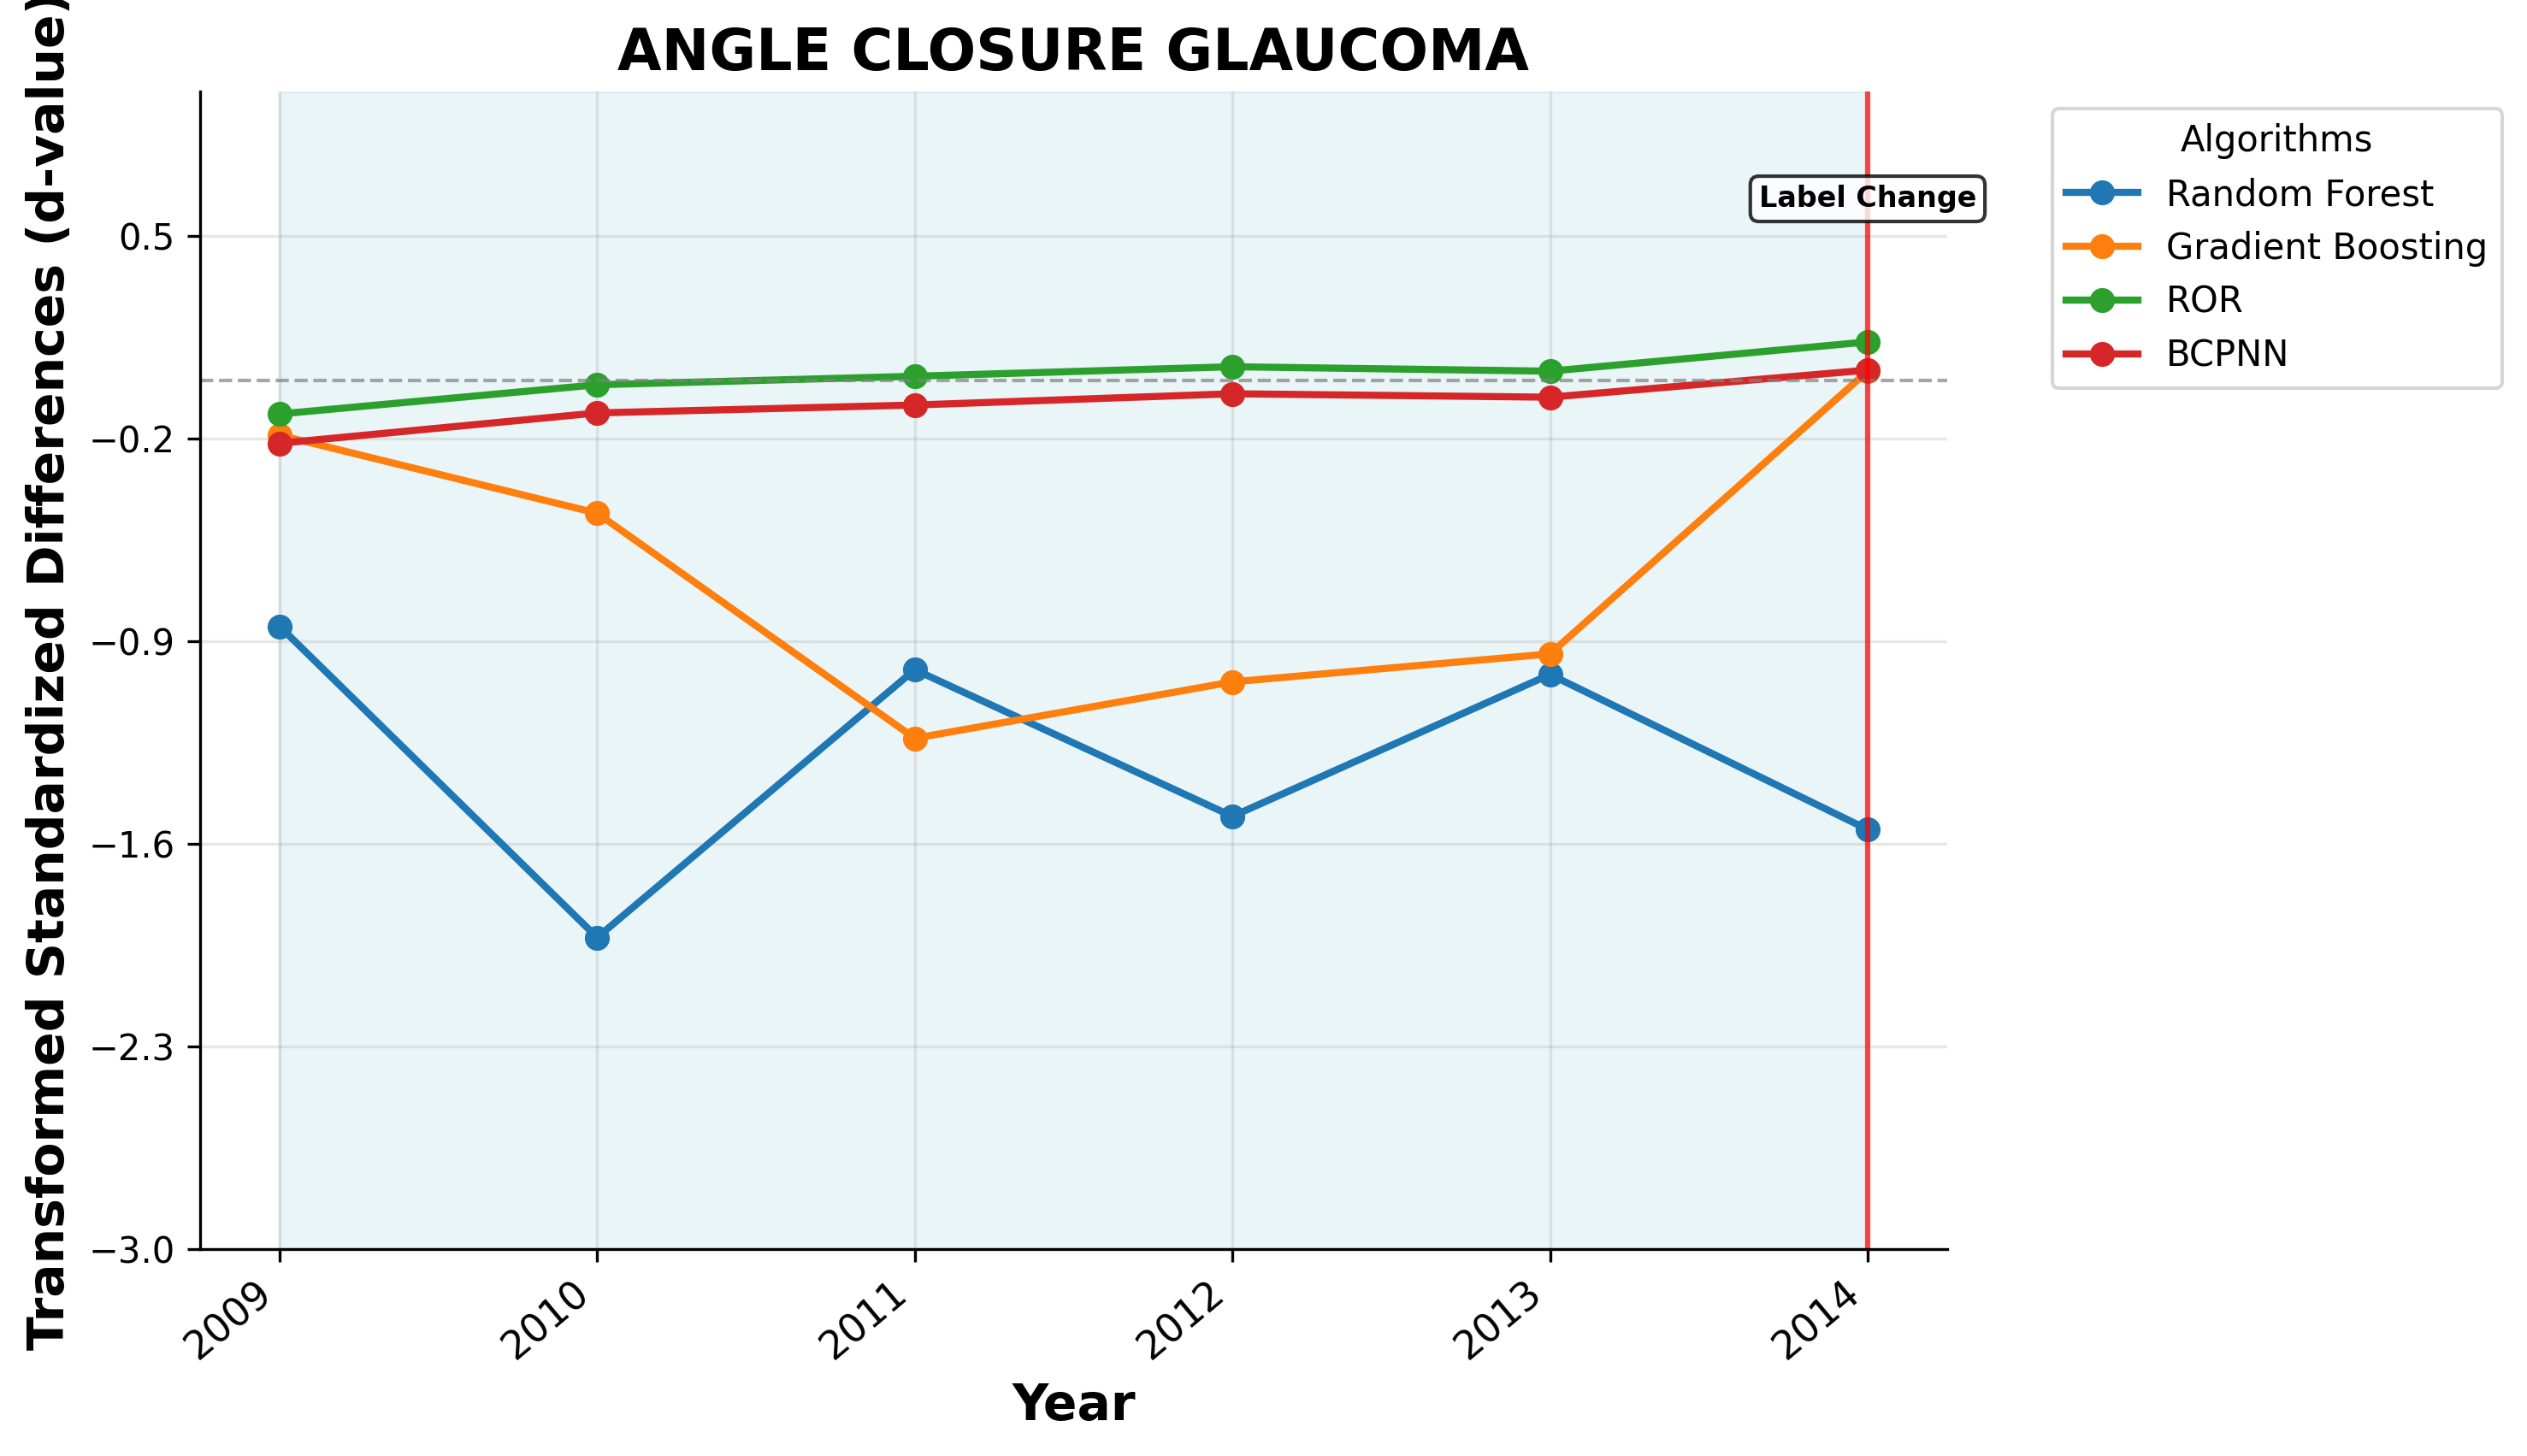

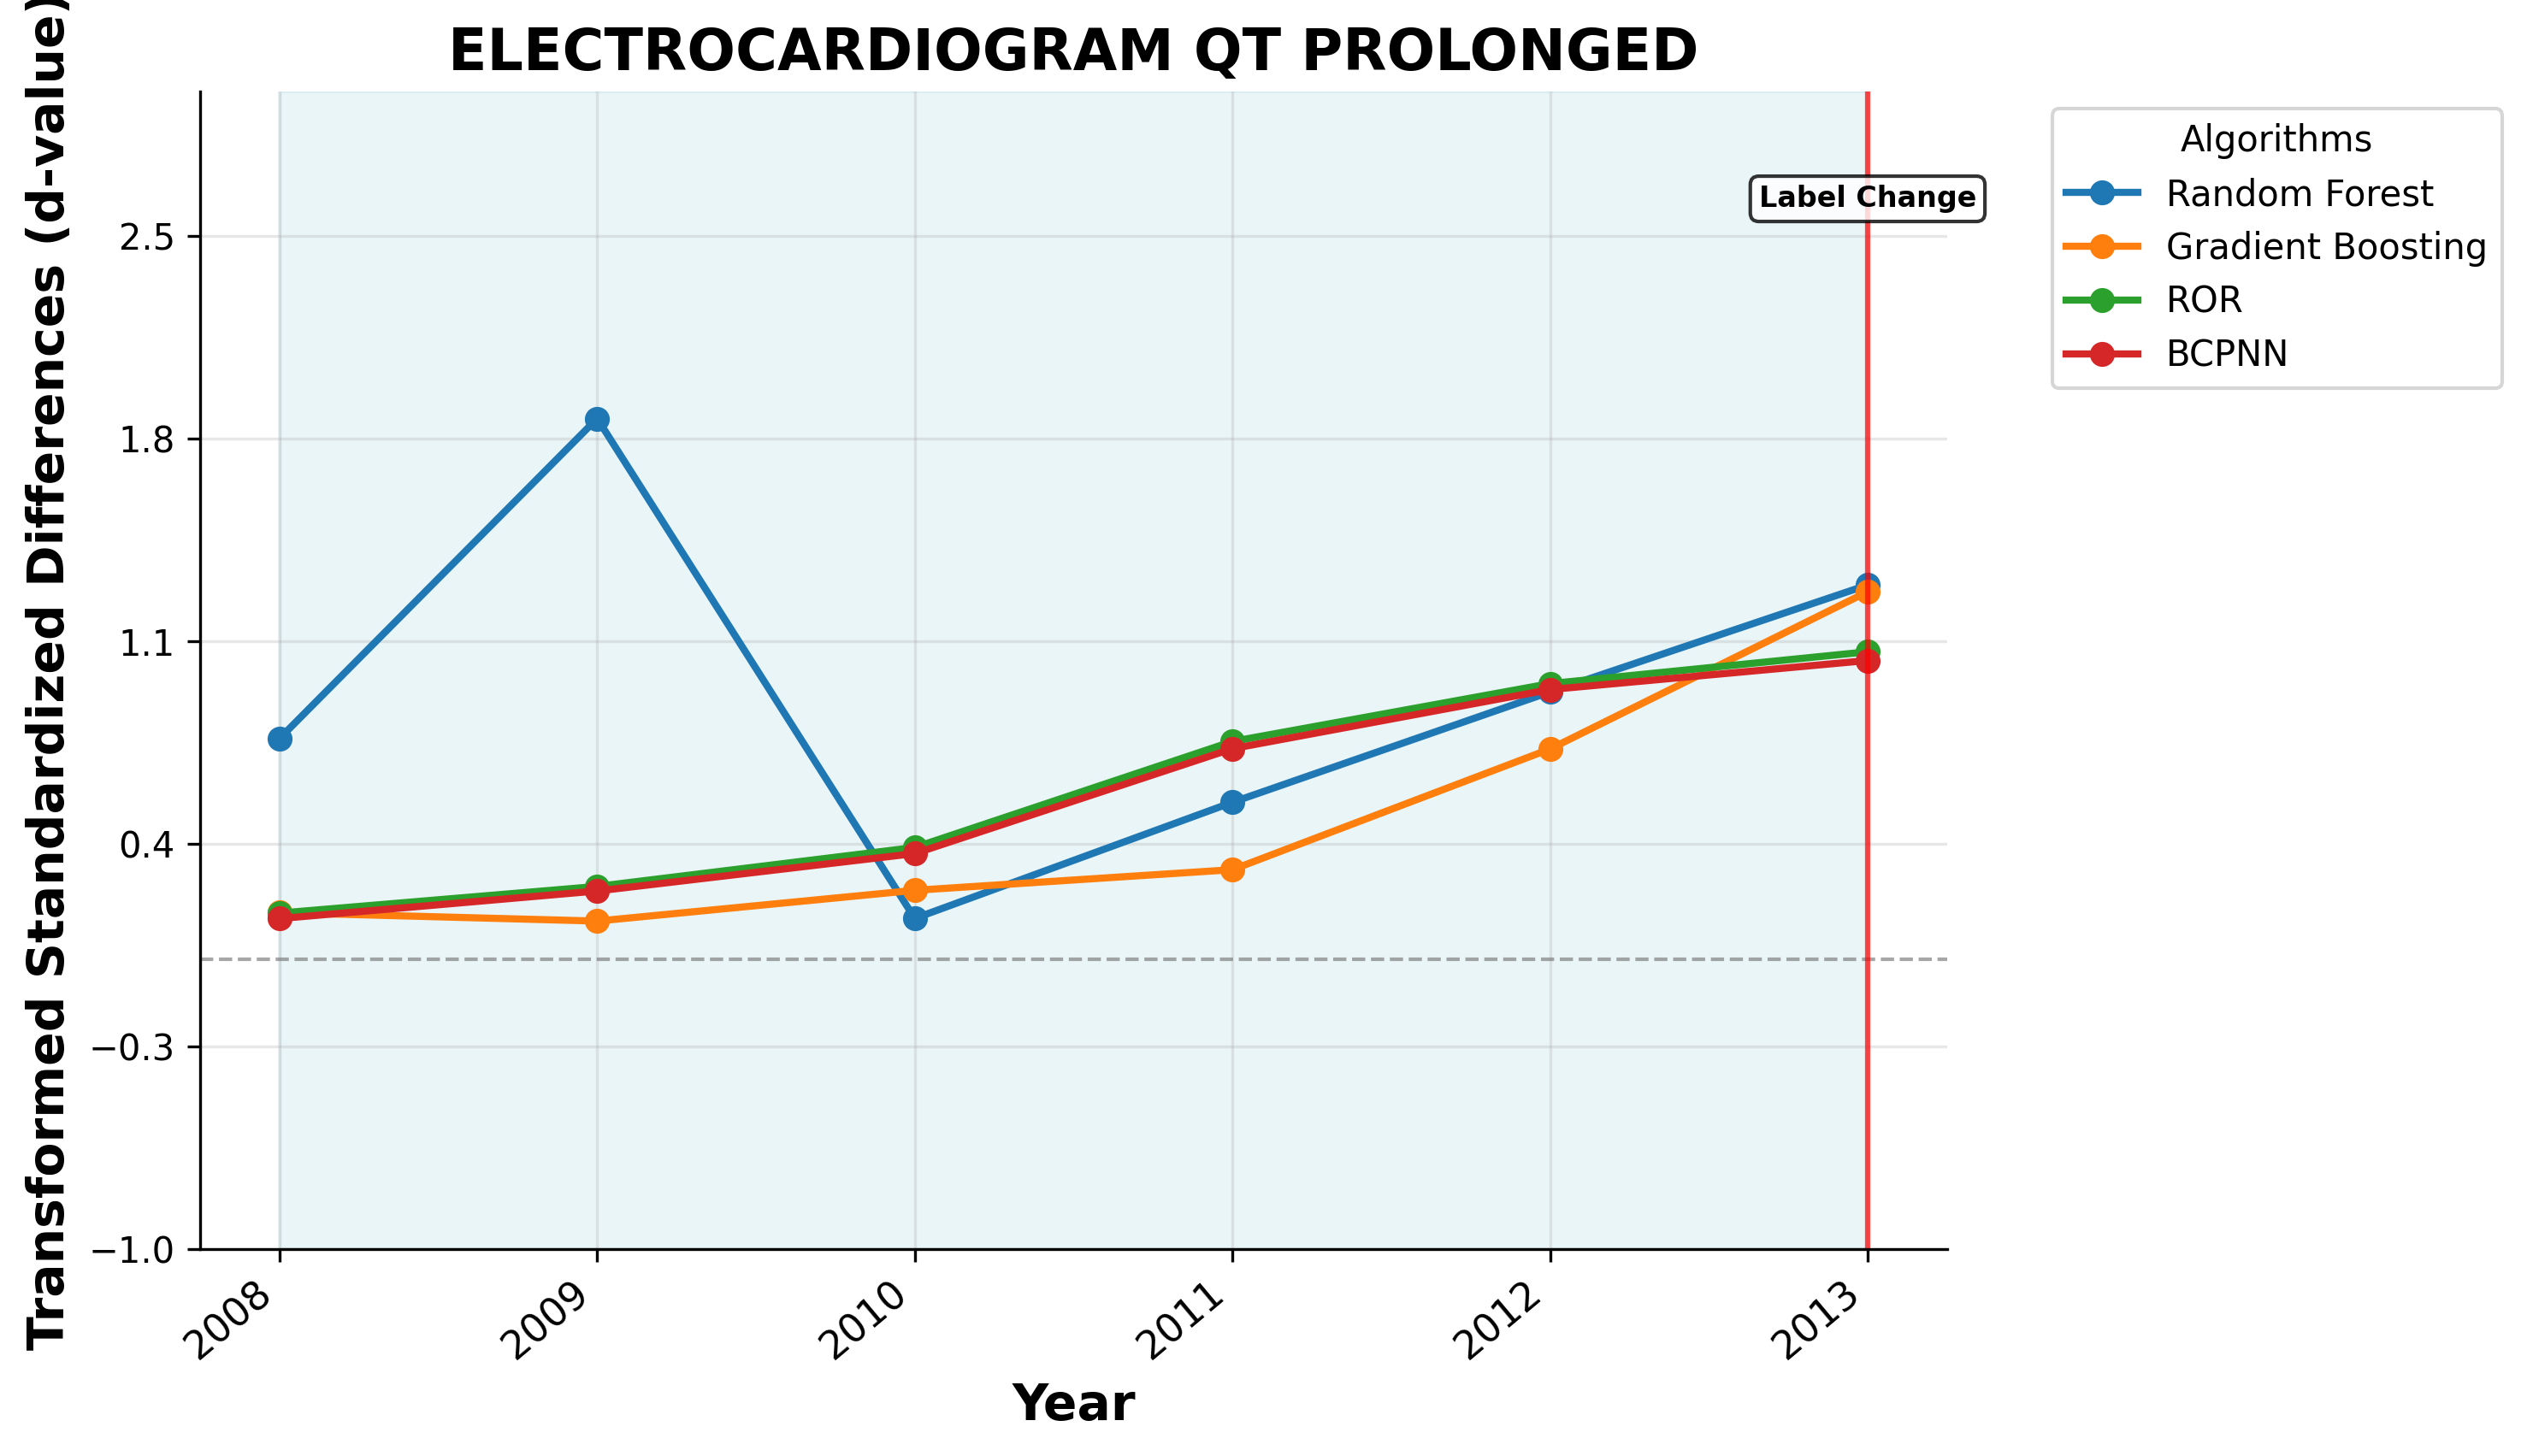

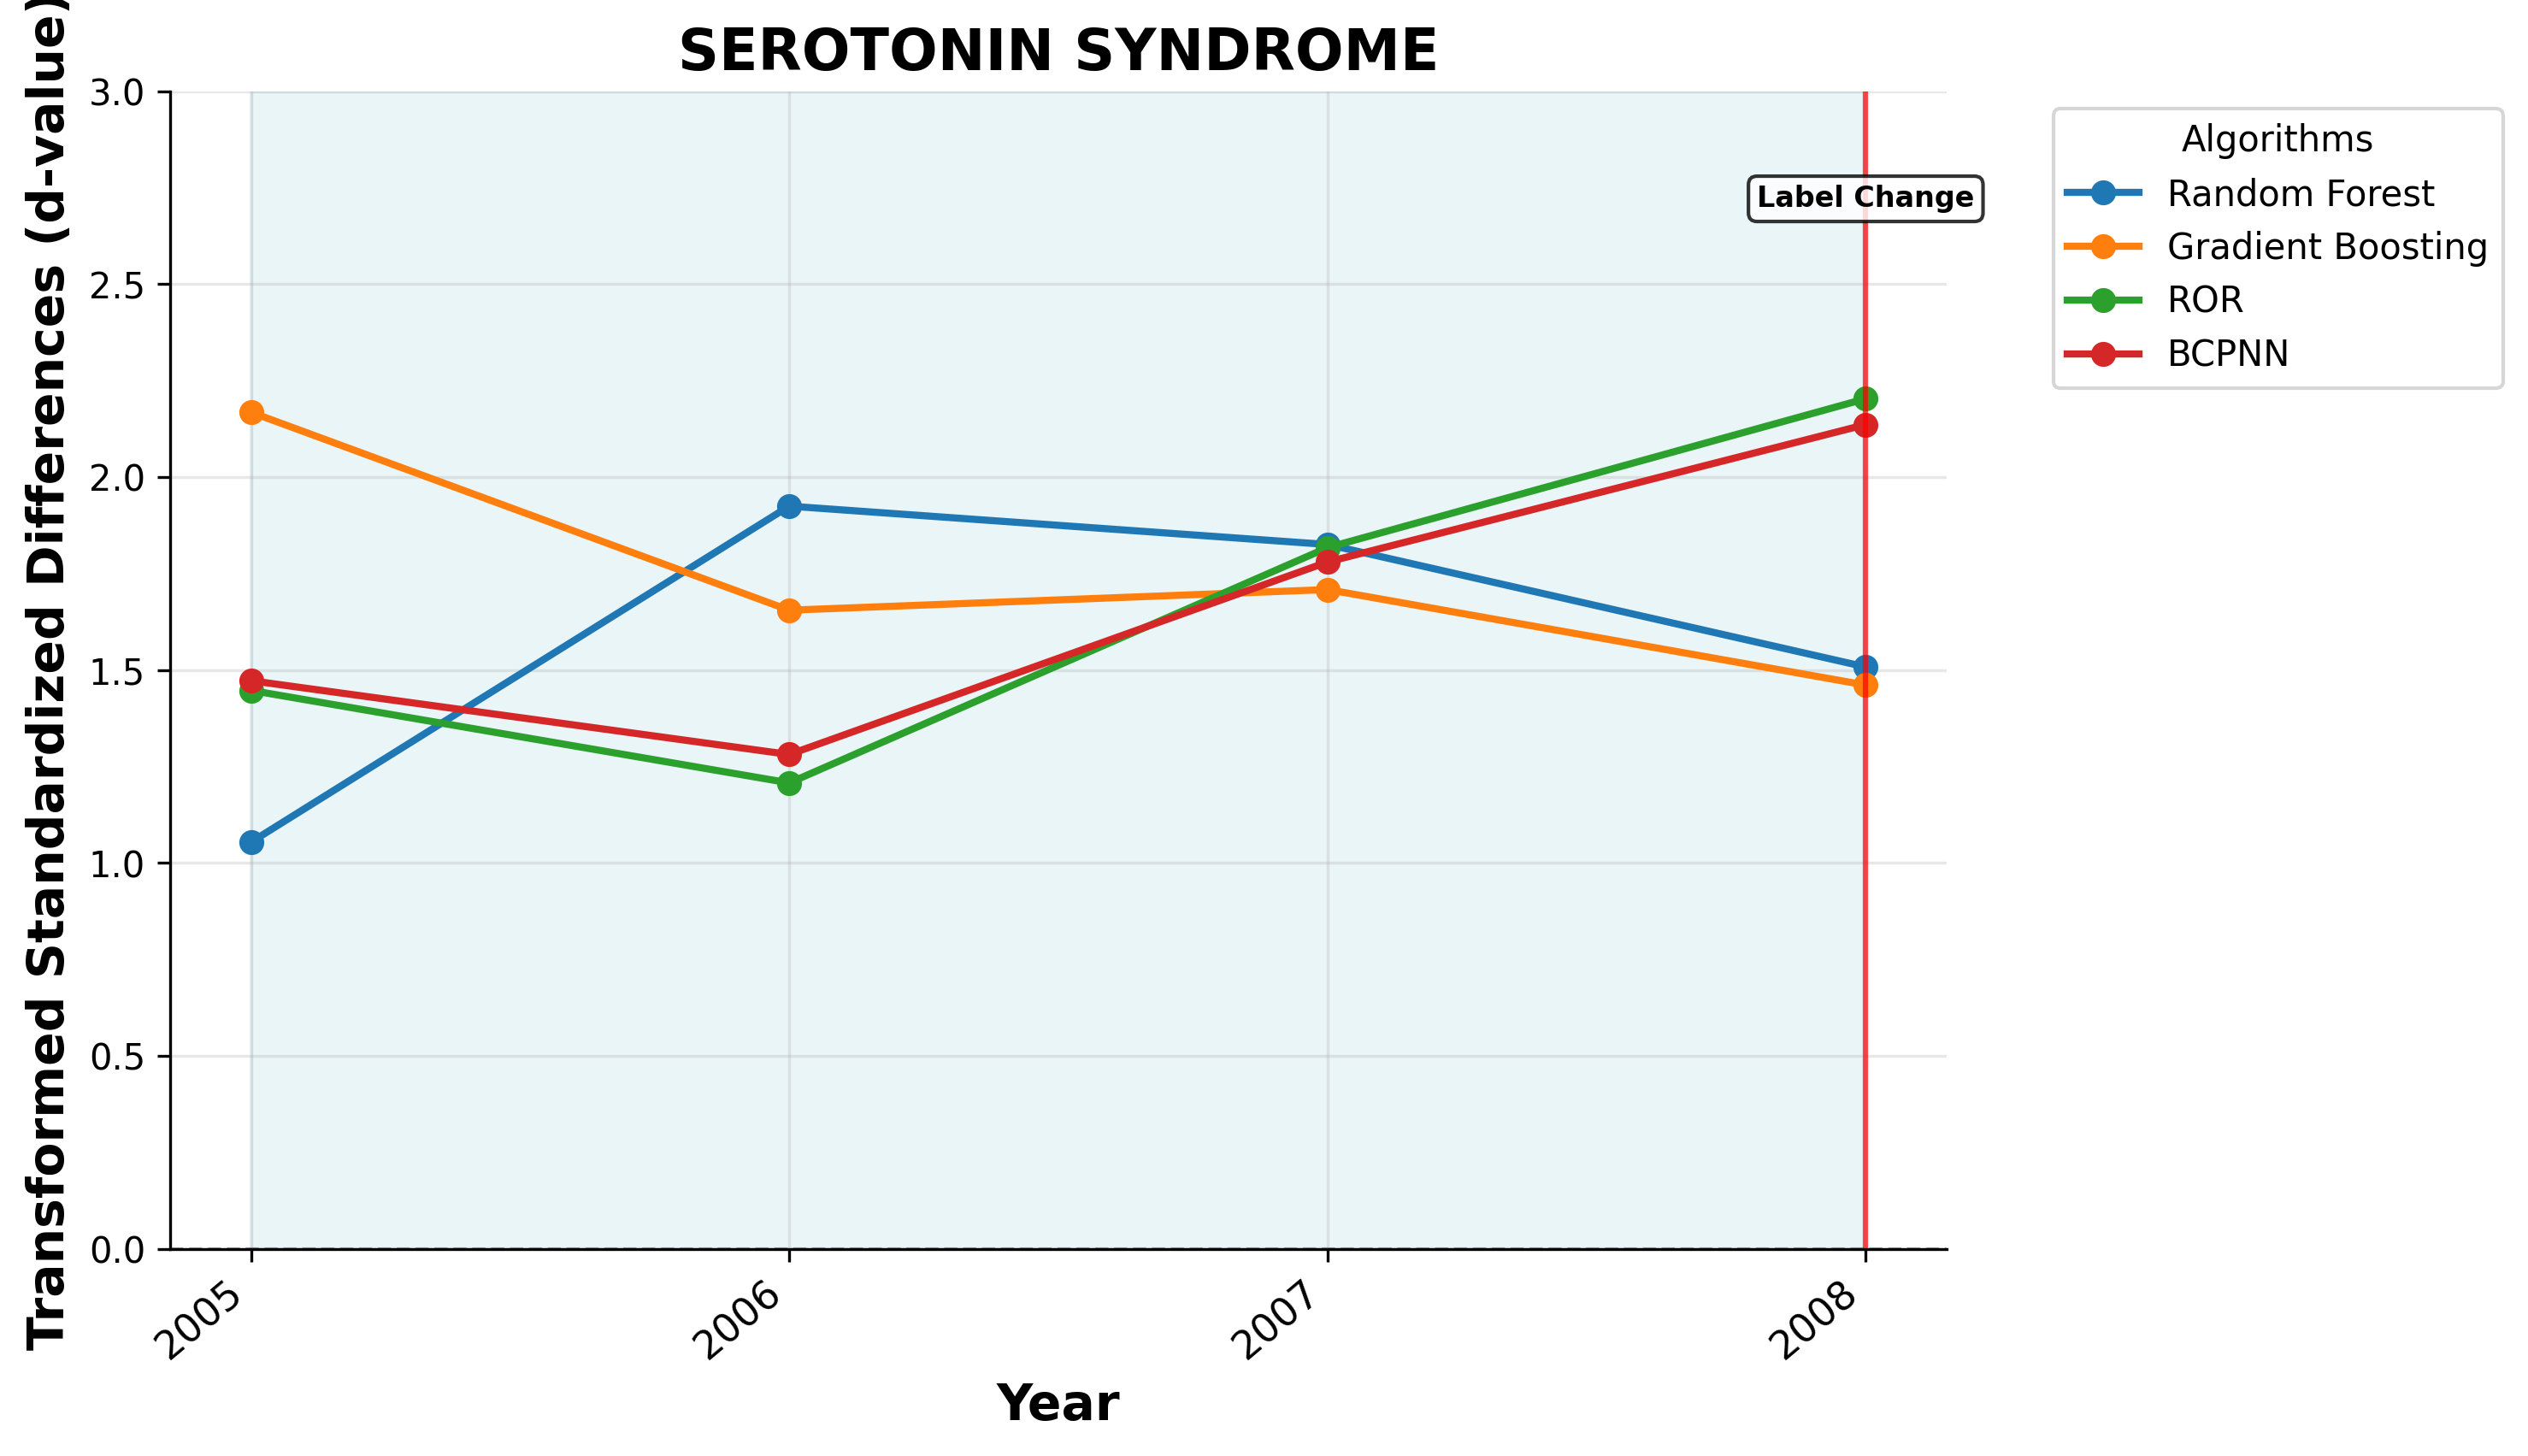

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Mapping of PT to label-change year (full year)
pt_configs = {
    'Sexual Dysfunction': 2021,
    'Angle-Closure Glaucoma': 2014,
    'ELECTROCARDIOGRAM QT PROLONGED': 2013,
    'Serotonin Syndrome': 2008}

def format_year(year):
    year_int = int(year)
    if year_int < 10:
        return f'200{year_int}'
    elif year_int < 100:
        return f'20{year_int:02d}'
    else:
        return str(year_int)

for pt_name, label_year_full in pt_configs.items():
    # Normalize name to match file naming
    safe_name = pt_name.upper().replace(' ', '_').replace('-', '_').replace('/', '_')
    # Convert full label-change year to the scale used in the data (e.g., 2021 -> 21, 2008 -> 8)
    if label_year_full >= 2000:
        label_year = int(str(label_year_full)[-2:])
    else:
        label_year = label_year_full

    input_path = f"{base_path}/FilteredYearlyBasedPerformance/{safe_name}.xlsx"
    output_path = f"{base_path}/FilteredYearlyBasedPerformance/{safe_name}.png"

    if not os.path.exists(input_path):
        print(f"Warning: File not found for PT '{pt_name}': {input_path}")
        continue

    df = pd.read_excel(input_path)

    
    # Determine d-value columns to plot
    algorithms = ['RF_d_value_transformed', 'GB_d_value_transformed', 'ROR_d_value_transformed', 'BCPNN_d_value_transformed']
    labels = ['Random Forest', 'Gradient Boosting', 'ROR', 'BCPNN']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    # Automatic y-range based on data with padding
    # Collect all values across the four algorithms, ignoring NaNs
    all_values = pd.concat([df[alg] for alg in algorithms], axis=0).dropna()
    if all_values.empty:
        print(f"No d-value data for PT '{pt_name}' in {input_path}, skipping.")
        continue

    vmin = all_values.min()
    vmax = all_values.max()
    padding = (vmax - vmin) * 0.1 if (vmax - vmin) != 0 else 1  # 10% padding or default 1
    y_lower = np.floor(vmin - padding)
    y_upper = np.ceil(vmax + padding)

    # If range is too narrow, ensure some minimal span
    if y_upper - y_lower < 1:
        center = (vmax + vmin) / 2
        y_lower = center - 1
        y_upper = center + 1

    # Tick spacing: aim for about 6-8 ticks
    raw_range = y_upper - y_lower
    # choose tick step as a round number
    step = max(0.1, round(raw_range / 6, 1))
    yticks = np.arange(y_lower, y_upper + 1e-6, step)

    # Plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    for algorithm, label, color in zip(algorithms, labels, colors):
        ax.plot(df['Year'], df[algorithm],
                marker='o', linewidth=2, markersize=6,
                label=label, color=color)

    # Adaptive y-axis
    ax.set_ylim(y_lower, y_upper)
    ax.set_yticks(yticks)

    # Horizontal baseline
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=1)

    # Shaded region before label change
    left_years = df[df['Year'] <= label_year]['Year']
    if len(left_years) > 0:
        ax.fill_between(left_years, y_lower, y_upper, alpha=0.25, color='lightblue')

    # Vertical line at label change
    ax.axvline(x=label_year, color='red', linestyle='-', alpha=0.7, linewidth=1.5)
    # Place annotation slightly below top of axis
    annotation_y = y_upper - (y_upper - y_lower) * 0.1
    ax.text(label_year, annotation_y, 'Label Change',
            horizontalalignment='center', fontsize=8, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Labels and title
    ax.set_xlabel('Year', fontsize=14, fontweight='bold')
    ax.set_ylabel('Transformed Standardized Differences (d-value)', fontsize=14, fontweight='bold')
    ax.set_title(pt_name.upper().replace('-', ' '), fontsize=16, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=40, ha='right', fontsize=11)  


    # X-axis formatting
    x_labels = [format_year(year) for year in df['Year']]
    ax.set_xticks(df['Year'])
    ax.set_xticklabels(x_labels)

    # Legend outside
    ax.legend(title='Algorithms', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()    
    plt.subplots_adjust(bottom=0.18)
    os.makedirs(f"{base_path}/YearlyBasedPerformance", exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
import pandas as pd
import numpy as np
import os

def extract_emergence_and_leadtime(
    excel_path: str,
    label_change_year: int,
    methods: list[str] = ['RF', 'GB', 'ROR', 'BCPNN'],
    d_suffix: str = '_d_value_transformed'
) -> pd.DataFrame:
    """
    Load a PT’s yearly summary, normalize Year to full 4-digit form,
    then compute for each method:
      - EmergenceYear: first full-year where d_value > 0
      - LabelChangeYear: as passed in
      - LeadTime = label_change_year - EmergenceYear
      - PeakDValue + PeakYear (full-year)
    """
    df = pd.read_excel(excel_path)

    # 1) normalize Year column to full 4-digit years
    def full_year(y):
        try:
            yi = int(y)
        except:
            return np.nan
        # assume any two-digit or one-digit <100 is 2000+yi
        return 2000 + yi if yi < 100 else yi

    df['Year'] = df['Year'].apply(full_year)

    results = []
    for m in methods:
        col = f"{m}{d_suffix}"
        if col not in df.columns:
            continue

        temp = df[['Year', col]].dropna(subset=[col]).sort_values('Year')

        # Emergence: first full-year where d>0
        emerged = temp[temp[col] > 0]
        if not emerged.empty:
            emergence_year = int(emerged['Year'].iloc[0])
        else:
            emergence_year = np.nan

        # Lead time
        lead_time = (int(label_change_year) - emergence_year
                     if not np.isnan(emergence_year) else np.nan)

        # Peak
        peak_idx = temp[col].idxmax()
        peak_row = temp.loc[peak_idx]
        peak_val  = float(peak_row[col])
        peak_year = int(peak_row['Year'])

        results.append({
            'Method':          m,
            'EmergenceYear':   emergence_year,
            'LabelChangeYear': int(label_change_year),
            'LeadTime':        lead_time,
            'PeakDValue':      peak_val,
            'PeakYear':        peak_year
        })

    return pd.DataFrame(results)


# Example batch across all PTs

all_summaries = []
pt_configs = {
    'SEXUAL_DYSFUNCTION':             2021,
    'ANGLE_CLOSURE_GLAUCOMA':         2014,
    'ELECTROCARDIOGRAM_QT_PROLONGED': 2013,
    'SEROTONIN_SYNDROME':             2008,
}
for pt, yr in pt_configs.items():
    infile = f"{base_path}/YearlyBasedPerformance/{pt}.xlsx"
    df_pt = extract_emergence_and_leadtime(infile, yr)
    df_pt.insert(0, 'PT', pt)
    all_summaries.append(df_pt)

final = pd.concat(all_summaries, ignore_index=True)
final.to_excel(f"{base_path}/SignalSummarise/Summary_Emergence_LeadTime.xlsx", index=False)

final


,PT,Method,EmergenceYear,LabelChangeYear,LeadTime,PeakDValue,PeakYear
0,SEXUAL_DYSFUNCTION,RF,2005.0,2021,16.0,0.768968,2010
1,SEXUAL_DYSFUNCTION,GB,2016.0,2021,5.0,0.397631,2016
2,SEXUAL_DYSFUNCTION,ROR,2005.0,2021,16.0,3.410851,2017
3,SEXUAL_DYSFUNCTION,BCPNN,2005.0,2021,16.0,3.312250,2017
4,ANGLE_CLOSURE_GLAUCOMA,RF,NaN,2014,NaN,-0.321000,2007
5,ANGLE_CLOSURE_GLAUCOMA,GB,2005.0,2014,9.0,0.066450,2007
6,ANGLE_CLOSURE_GLAUCOMA,ROR,2008.0,2014,6.0,1.806331,2017
7,ANGLE_CLOSURE_GLAUCOMA,BCPNN,2014.0,2014,0.0,1.608807,2017
8,ELECTROCARDIOGRAM_QT_PROLONGED,RF,2006.0,2013,7.0,1.868952,2009
9,ELECTROCARDIOGRAM_QT_PROLONGED,GB,2006.0,2013,7.0,1.926740,2017


In [ ]:
import pandas as pd

def summarize_detection_performance(final: pd.DataFrame) -> pd.DataFrame:
    # group by method
    grp = final.groupby('Method')

    summary = grp.agg(
        NumPTs = ('PT','nunique'),
        NumDetected  = ('EmergenceYear', lambda x: x.notna().sum()),
        AverageLeadTime = ('LeadTime','mean')).reset_index()

    # compute detection rate
    summary['DetectionRate'] = summary['NumDetected'] / summary['NumPTs']

    # round for readability
    summary['DetectionRate'] = summary['DetectionRate'].round(2)
    summary['AverageLeadTime'] = summary['AverageLeadTime'].round(2)

    return summary[['Method','DetectionRate','AverageLeadTime','NumPTs','NumDetected']]

perf_table = summarize_detection_performance(final)
perf_table.to_excel(f'{base_path}/SignalSummarise/Method_Detection_Performance.xlsx', index=False)
perf_table


,Method,DetectionRate,AverageLeadTime,NumPTs,NumDetected
0,BCPNN,1.00,2006.50,4,4
1,GB,1.00,2006.00,4,4
2,RF,0.75,2008.67,4,3
3,ROR,1.00,2008.00,4,4


#### Different Measures Experiment

##### Thresholds of D_Value

In [ ]:
import pandas as pd
import os

# mapping of PT to its label change year
LABEL_CHANGE_YEAR = {
    'SEXUAL DYSFUNCTION': 2021,
    'ANGLE CLOSURE GLAUCOMA': 2014,
    'ELECTROCARDIOGRAM QT PROLONGED': 2013,
    'SEROTONIN SYNDROME': 2008
}

# Methods and their transformed d-value column names in the yearly Excel
METHOD_COLUMNS = {
    'RF': 'RF_d_value_transformed',
    'GB': 'GB_d_value_transformed',
    'ROR': 'ROR_d_value_transformed',
    'BCPNN': 'BCPNN_d_value_transformed'
}


def extract_emergence_and_leadtime(pt_name, threshold=2.0, base_path=base_path):
    """
    For a given PT, load its yearly summary Excel and compute for each method:
      - first year the transformed d-value exceeds the threshold
      - lead time = label change year - emergence year (positive means early detection)
    Returns a DataFrame with columns: Method, EmergenceYear, LabelChangeYear, LeadTime, PeakDValue, PeakYear
    """
    safe_name = pt_name.replace(' ', '_').replace('/', '_')
    file_path = os.path.join(base_path, 'YearlyBasedPerformance', f"{safe_name}.xlsx")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Yearly file for PT '{pt_name}' not found at {file_path}")
    
    df = pd.read_excel(file_path)
    results = []
    label_year = LABEL_CHANGE_YEAR.get(pt_name)
    if label_year is None:
        raise KeyError(f"No label change year defined for PT '{pt_name}'")
    
    for method, col in METHOD_COLUMNS.items():
        if col not in df.columns:
            # skip if missing
            results.append({
                'Method': method,
                'EmergenceYear': None,
                'LabelChangeYear': label_year,
                'LeadTime': None,
                'Peak-D-Value': None,
                'PeakYear': None
            })
            continue

        # Find first year crossing threshold (assuming positive signal)
        # Allow NaNs; drop them
        valid = df[['Year', col]].dropna()
        crossed = valid[valid[col] >= threshold]
        emergence_year = int(crossed['Year'].iloc[0]) if not crossed.empty else None

        # Peak (max) d-value and its year to give context
        if not valid.empty:
            peak_idx = valid[col].idxmax()
            peak_year = int(df.loc[peak_idx, 'Year'])
            peak_val = float(df.loc[peak_idx, col])
        else:
            peak_year = None
            peak_val = None

        lead_time = None
        if emergence_year is not None:
            lead_time = label_year - emergence_year  # positive -> detected before label change

        results.append({
            'Method': method,
            'EmergenceYear': emergence_year,
            'LabelChangeYear': label_year,
            'LeadTime': lead_time,
            'Peak-D-Value': peak_val,
            'PeakYear': peak_year
        })

    return pd.DataFrame(results)


def summarize_all_pts(threshold=2.0, base_path='.'):
    """
    Loop over all configured PTs, extract emergence and lead time, and combine into summary table.
    """
    all_records = []
    for pt in LABEL_CHANGE_YEAR.keys():
        df_pt = extract_emergence_and_leadtime(pt, threshold=threshold, base_path=base_path)
        df_pt['PT'] = pt
        all_records.append(df_pt)
    summary = pd.concat(all_records, ignore_index=True)
    # reorder columns
    summary = summary[['PT', 'Method', 'EmergenceYear', 'LabelChangeYear', 'LeadTime', 'Peak-D-Value', 'PeakYear']]
    return summary


In [75]:
import numpy as np

def compute_null_stats(pt_list, base_path=base_path):
    # Collect all pre-label d-values per method for null
    null_vals = {method: [] for method in METHOD_COLUMNS}
    for pt in pt_list:
        label_year = LABEL_CHANGE_YEAR[pt]
        safe_name = pt.replace(' ', '_').replace('/', '_')
        df = pd.read_excel(os.path.join(base_path, 'YearlyBasedPerformance', f"{safe_name}.xlsx"))
        for method, col in METHOD_COLUMNS.items():
            if col not in df.columns:
                continue
            prelabel = df[df['Year'] < label_year][col].dropna()
            null_vals[method].extend(prelabel.tolist())
    # Compute mean/std or empirical percentiles
    stats = {}
    for method, vals in null_vals.items():
        arr = np.array(vals)
        stats[method] = {
            'mean': np.mean(arr),
            'std': np.std(arr, ddof=1),
            'percentiles': {
                p: np.percentile(arr, p) for p in [90, 95, 97.5, 99]
            }
        }
    return stats

def threshold_sweep(pt_list, base_path=base_path, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(1.0, 3.01, 0.25)
    records = []
    for method in METHOD_COLUMNS:
        for thr in thresholds:
            per_pt_leadtimes = []
            detected = 0
            for pt in pt_list:
                df_summary = extract_emergence_and_leadtime(pt, threshold=thr, base_path=base_path)
                row = df_summary[df_summary['Method'] == method].iloc[0]
                lt = row['LeadTime']
                if lt is not None and lt >= 0:
                    detected += 1
                    per_pt_leadtimes.append(lt)
            detection_rate = detected / len(pt_list)
            avg_lead = np.mean(per_pt_leadtimes) if per_pt_leadtimes else np.nan
            records.append({
                'Method': method,
                'Threshold': thr,
                'DetectionRate': detection_rate,
                'AverageLeadTime': avg_lead
            })
    return pd.DataFrame(records)


In [76]:
null_stats = compute_null_stats(special_pts, base_path)
# Flatten percentiles for each method
flat_records = []
for method, stats in null_stats.items():
    row = {
        'Method': method,
        'Mean': stats.get('mean'),
        'Std': stats.get('std')
    }
    # Add percentiles as separate columns
    percentiles = stats.get('percentiles', {})
    for p, val in percentiles.items():
        row[f'Percentile_{p}'] = val
    flat_records.append(row)

Null_Distribution_Estimates = pd.DataFrame(flat_records)
Null_Distribution_Estimates.to_excel(f'{base_path}/Null_Distribution_Estimates.xlsx')
Null_Distribution_Estimates

,Method,Mean,Std,Percentile_90,Percentile_95,Percentile_97.5,Percentile_99
0,RF,0.204125,1.036722,1.626737,1.790763,1.887052,1.935639
1,GB,-0.010649,1.038728,1.462755,1.689697,1.915555,2.006360
2,ROR,1.597961,1.286904,3.391449,3.810976,3.860197,3.897099
3,BCPNN,1.524680,1.263429,3.276060,3.686290,3.729699,3.773740


In [77]:
Threshold_Test = threshold_sweep(special_pts, base_path)
Threshold_Test.to_excel(f'{base_path}/Threshold_Test.xlsx', index=False)
Threshold_Test

,Method,Threshold,DetectionRate,AverageLeadTime
0,RF,1.00,0.50,2003.500000
1,RF,1.25,0.50,2003.000000
2,RF,1.50,0.50,2003.000000
3,RF,1.75,0.50,2003.000000
4,RF,2.00,0.00,NaN
5,RF,2.25,0.00,NaN
6,RF,2.50,0.00,NaN
7,RF,2.75,0.00,NaN
8,RF,3.00,0.00,NaN
9,GB,1.00,0.50,2001.500000


In [109]:
summary_df = summarize_all_pts(threshold=2, base_path=base_path)
print(summary_df.to_string(index=False))
summary_df.to_excel(f'{base_path}/SignalSummaries/Threshold_D_Value.xlsx')

                            PT Method  EmergenceYear  LabelChangeYear  LeadTime  Peak-D-Value  PeakYear
            SEXUAL DYSFUNCTION     RF            NaN             2021       NaN      0.768968        10
            SEXUAL DYSFUNCTION     GB            NaN             2021       NaN      0.397631        16
            SEXUAL DYSFUNCTION    ROR            8.0             2021    2013.0      3.410851        17
            SEXUAL DYSFUNCTION  BCPNN           10.0             2021    2011.0      3.312250        17
        ANGLE CLOSURE GLAUCOMA     RF            NaN             2014       NaN     -0.321000         7
        ANGLE CLOSURE GLAUCOMA     GB            NaN             2014       NaN      0.066450         7
        ANGLE CLOSURE GLAUCOMA    ROR            NaN             2014       NaN      1.806331        17
        ANGLE CLOSURE GLAUCOMA  BCPNN            NaN             2014       NaN      1.608807        17
ELECTROCARDIOGRAM QT PROLONGED     RF            NaN            

##### Threshold_Standardized_Z_Score

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# mapping of PT to its label change year
label_years_map = {
    'SEXUAL DYSFUNCTION': 2021,
    'ANGLE CLOSURE GLAUCOMA': 2014,
    'ELECTROCARDIOGRAM QT PROLONGED': 2013,
    'SEROTONIN SYNDROME': 2008
}

# Methods and their transformed d-value column names in the yearly Excel
methods = ['RF', 'GB', 'ROR', 'BCPNN']


def compute_null_stats2(df, methods, pre_label_years):
    """
    Estimate null mean/std for each method from years <= max(pre_label_years)
    Assumes df has columns like 'RF_d_value', 'GB_d_value', etc., and 'Year'.
    Returns dict: {method: {'mean':..., 'std':...}}
    """
    null_stats = {}
    null_df = df[df['Year'].isin(pre_label_years)]
    for method in methods:
        col = f"{method}_d_value_transformed"
        if col not in df.columns:
            raise KeyError(f"{col} missing from dataframe")
        vals = null_df[col].dropna()
        if len(vals) < 2:
            # fallback to global if insufficient pre-label data
            vals = df[col].dropna()
        mean = vals.mean()
        std = vals.std(ddof=0) if vals.std(ddof=0) > 0 else 1.0  # avoid zero
        null_stats[method] = {'mean': mean, 'std': std}
    return null_stats

def standardize_d_values(df, null_stats, methods):
    """
    Adds z-score columns for each method: e.g. 'RF_z'
    """
    out = df.copy()
    for method in methods:
        dcol = f"{method}_d_value_transformed"
        zcol = f"{method}_z"
        mean = null_stats[method]['mean']
        std = null_stats[method]['std']
        out[zcol] = (out[dcol] - mean) / std
    return out

def detect_emergence(z_series, threshold=1.645, persistence=1):
    """
    Returns the first index (year) where z_series crosses threshold and
    persists for `persistence` consecutive years. If none, returns None.
    z_series is assumed indexed by year sorted ascending.
    """
    years = z_series.index.to_list()
    zs = z_series.values
    for i in range(len(zs) - persistence + 1):
        window = zs[i:i+persistence]
        if np.all(window >= threshold):
            return years[i]
    return None

def summarize_signal_emergence(df, label_change_year, pt_name, methods,
                               threshold=1.645, persistence=1):
    """
    df: yearly d-value dataframe for one PT, must have Year column.
    label_change_year: integer (e.g., 2008 for SS)
    methods: list of method short names, e.g. ['RF','GB','ROR','BCPNN']
    Returns DataFrame with emergence year and lead time per method.
    """
    # Define pre-label years for null estimation (all years strictly before label change)
    pre_label_years = [y for y in df['Year'].unique() if y < label_change_year]
    null_stats = compute_null_stats2(df, methods, pre_label_years)
    df_std = standardize_d_values(df, null_stats, methods)

    summary_rows = []
    for method in methods:
        zcol = f"{method}_z"
        if zcol not in df_std.columns:
            continue
        # Build series indexed by Year to feed detector
        series = df_std.set_index('Year')[zcol].sort_index()
        emergence_year = detect_emergence(series, threshold=threshold, persistence=persistence)
        signal_detected = emergence_year is not None and emergence_year <= label_change_year
        lead_time = None
        if signal_detected:
            lead_time = label_change_year - emergence_year
        summary_rows.append({
            'PT': pt_name,
            'Method': method,
            'Threshold_z': threshold,
            'EmergenceYear': emergence_year,
            'LabelChangeYear': label_change_year,
            'LeadTime': lead_time,
            'SignalDetected': signal_detected,
            'NullMean': null_stats[method]['mean'],
            'NullStd': null_stats[method]['std']
        })

    return pd.DataFrame(summary_rows)




In [105]:
import pandas as pd
import numpy as np
import os

# --- reuse previously defined functions: ---
# compute_null_stats, standardize_d_values, detect_emergence, summarize_signal_emergence
# (Assume those are already in scope or import them if placed in a module)

def batch_process_all_pts(base_path, pt_label_year_map, methods,
                          threshold=1.645, persistence=1):
    """
    Process all PTs, summarize emergence, then aggregate comparison metrics.
    Args:
        base_path: root path where YearlyBasedPerformance/*.xlsx lives
        pt_label_year_map: dict mapping PT name to label change year
        methods: list of method short names e.g. ['RF','GB','ROR','BCPNN']
        threshold: common z-score threshold for signal emergence
        persistence: consecutive years requirement
    Returns:
        summary_all: DataFrame with per-PT-per-method emergence info
        metrics: DataFrame with detection rate and average lead time per method
    """
    summary_frames = []
    for pt, label_year in pt_label_year_map.items():
        # safe filename: replace spaces/slashes with underscore to match saved Excel
        safe_name = pt.replace(' ', '_').replace('/', '_')
        input_file = os.path.join(base_path, "YearlyBasedPerformance", f"{safe_name}.xlsx")
        if not os.path.exists(input_file):
            print(f"[WARN] File missing for PT '{pt}': {input_file}")
            continue
        df = pd.read_excel(input_file)

        summary_df = summarize_signal_emergence(
            df=df,
            label_change_year=label_year,
            pt_name=pt,
            methods=methods,
            threshold=threshold,
            persistence=persistence
        )
        summary_frames.append(summary_df)

    if not summary_frames:
        raise RuntimeError("No PT summaries generated.")

    summary_all = pd.concat(summary_frames, ignore_index=True)

    # Compute aggregated metrics per method
    metrics_list = []
    for method in methods:
        subset = summary_all[summary_all['Method'] == method]
        if subset.empty:
            continue
        total_pts = subset.shape[0]
        detected = subset['SignalDetected'].sum()
        detection_rate = detected / total_pts if total_pts > 0 else 0

        # Only consider lead times for detected signals
        lead_times = subset.loc[subset['SignalDetected'], 'LeadTime']
        avg_lead_time = lead_times.mean() if not lead_times.empty else np.nan

        metrics_list.append({
            'Method': method,
            'DetectionRate': detection_rate,
            'AverageLeadTime': avg_lead_time,
            'NumPTs': total_pts,
            'NumDetected': int(detected)
        })

    metrics = pd.DataFrame(metrics_list).sort_values(by='DetectionRate', ascending=False)
    return summary_all, metrics


# === Example invocation ===
if __name__ == "__main__":
    base_path = "/Users/nyki/Desktop/2025/Research Project/EarlySignalDetection"  # adjust to real base path
    pt_label_year_map = {
        'SEXUAL DYSFUNCTION': 2021,
        'ANGLE CLOSURE GLAUCOMA': 2014,
        'ELECTROCARDIOGRAM QT PROLONGED': 2013,
        'SEROTONIN SYNDROME': 2008
    }

    methods = ['RF', 'GB', 'ROR', 'BCPNN']
    threshold_z = 1.645 # one-sided ~95% significance
    persistence_years = 1  # require 1 year crossing; increase to 2 to reduce noise

    summary_all, metrics = batch_process_all_pts(
        base_path=base_path,
        pt_label_year_map=pt_label_year_map,
        methods=methods,
        threshold=threshold_z,
        persistence=persistence_years
    )

    # Save outputs
    os.makedirs(os.path.join(base_path, "SignalSummaries"), exist_ok=True)
    summary_all.to_excel(os.path.join(base_path, "SignalSummaries", "Threshold_Standardized_Z_Score.xlsx"), index=False)
    metrics.to_excel(os.path.join(base_path, "SignalSummaries", "Method_Comparison_Metrics.xlsx"), index=False)



In [106]:
summary_all

,PT,Method,Threshold_z,EmergenceYear,LabelChangeYear,LeadTime,SignalDetected,NullMean,NullStd
0,SEXUAL DYSFUNCTION,RF,1.645,10.0,2021,2011.0,True,-0.199912,0.416933
1,SEXUAL DYSFUNCTION,GB,1.645,16.0,2021,2005.0,True,-0.683058,0.634600
2,SEXUAL DYSFUNCTION,ROR,1.645,NaN,2021,NaN,False,2.367036,0.780261
3,SEXUAL DYSFUNCTION,BCPNN,1.645,NaN,2021,NaN,False,2.283848,0.748715
4,ANGLE CLOSURE GLAUCOMA,RF,1.645,NaN,2014,NaN,False,-1.015203,0.472016
5,ANGLE CLOSURE GLAUCOMA,GB,1.645,NaN,2014,NaN,False,-0.876874,0.674144
6,ANGLE CLOSURE GLAUCOMA,ROR,1.645,NaN,2014,NaN,False,0.346499,0.922222
7,ANGLE CLOSURE GLAUCOMA,BCPNN,1.645,NaN,2014,NaN,False,0.239038,0.858101
8,ELECTROCARDIOGRAM QT PROLONGED,RF,1.645,NaN,2013,NaN,False,0.853790,0.655293
9,ELECTROCARDIOGRAM QT PROLONGED,GB,1.645,17.0,2013,1996.0,True,0.428230,0.609079


In [91]:
metrics

,Method,DetectionRate,AverageLeadTime,NumPTs,NumDetected
1,GB,0.75,2001.333333,4,3
0,RF,0.25,2011.000000,4,1
2,ROR,0.00,NaN,4,0
3,BCPNN,0.00,NaN,4,0
